In [ ]:
!git remote add origin https://github.com/ww81/subway-predict-project.git
!git branch -M main
!git push -u origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
  !pip install category_encoders==2.*
  !pip install pandas-profiling==2.*
  !pip install eli5
  !pip install pdpbox
  !pip install shap

#코랩에 나눔글꼴 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 불필요한 에러메세지 무시
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from pdpbox import pdp
import shap

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 0. 데이터 선정



최근 코로나로 인해 지하철 역사에 있는 가게들이 자리를 비우고 빈 가게가 된 것을 많이 볼 수 있었습니다. 서울 내 주요 역에서 가게를 운영한다고 가정하고 가게 운영에 도움이 되는 정보를 분석해보겠습니다. 

### 수집한 데이터

1. 서울 지하철역 승/하차 승객 데이터<br>
  * 보유특성: 사용일자, 노선명, 역명, 승차총승객수,	하차총승객수,	등록일자
  * 기간: 2016.01 ~ 2021.01 (5년 1개월)
  * 출처: 서울열린데이터광장 > 서울시 지하철호선별 역별 승하차 인원 정보(http://data.seoul.go.kr/dataList/OA-12914/S/1/datasetView.do#)

2. 서울시 코로나19 확진자 현황<br>
  * 보유특성:
  * 기간: 2020.01.24 ~ 2021.02.15 (서울 내 확진자 최초 발생일 이후 최근까지의 데이터) 
  * 출처: 서울열린데이터광장 > 서울시 코로나19 확진자 현황

3. 날씨 데이터<br>
  * 보유특성: 최저기온, 최고기온, 일강수량 등 
  * 기간: 2016.01 ~ 2021.01 (5년 1개월)
  * 출처: 기상자료개방포털>데이터>기상관측>종관기상관측(ASOS),황사관측(PM10)(https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36)
  * 수집 이유: 날씨도 대중교통 이용에 영향을 미칠 것이라고 생각되어 기온,비/눈 여부와 미세먼지 정보가 있는 날씨정보를 수집하였습니다.

### (취소)추가 조사 생성 데이터
*1. (취소)사회적 거리두기 정부지침 변천사<br>* *- 단계가 시간에 따라 수차례 개정되었고 상황에따라 지역마다 다르게 적용되어 이를 정량적으로 변환하는 것이 부정확하고 주관적인 요소가 많이 들어갈 것이라 생각되어 제외*
  * *출처: 사회적 거리 두기 정부 지침 변천사는 서울시와 정부 코로나 홈페이지 보도자료와 위키를 참고하였습니다.*
  * *수집 이유: 실제 코로나 확진자 수 보다 정부 대응책이 발표되었을 때 국민들의 즉각적인 행동변화가 일어날 수 있다고 생각했다.*


# 1. 데이터 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1-1.데이터 불러오기
여러 곳에서 수집한 데이터를 불러오고 형태를 확인한다. 

### 1) 날짜데이터

2016-01-01 부터 2021-01-31 까지의 날짜데이터를 생성하고<br>
요일과 주말여부를 추가하였다.

In [ ]:
#날짜 데이터 생성
df_date= pd.DataFrame({'날짜':pd.date_range(start='2016-01-01', end='2021-01-31')})
df_date['요일'] = df_date['날짜'].dt.day_name()
df_date["주말"] = np.where( (df_date['요일'] == 'Saturday') | (df_date['요일'] == 'Sunday') , 1,0 )
df_date

,날짜,요일,주말
0,2016-01-01,Friday,0
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
1853,2021-01-27,Wednesday,0
1854,2021-01-28,Thursday,0
1855,2021-01-29,Friday,0
1856,2021-01-30,Saturday,1


### 2) 지하철 이용 승객 데이터

#### (1) 데이터 확인

In [ ]:
#지하철 이용 승객 데이터 불러오기

df_subway = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/project2/CARD_SUBWAY_MONTH_201901.csv',encoding='cp949')
df_subway



,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
0,20190101,2호선,을지로4가,3862.0,3728.0,20190104
1,20190101,2호선,을지로3가,8104.0,7554.0,20190104
2,20190101,2호선,을지로입구,22478.0,21330.0,20190104
3,20190101,2호선,시청,8381.0,6049.0,20190104
4,20190101,1호선,동묘앞,8045.0,8504.0,20190104
...,...,...,...,...,...,...
18329,20190131,우이신설선,북한산보국문,6195.0,5786.0,20190203
18330,20190131,우이신설선,정릉,4600.0,4211.0,20190203
18331,20190131,우이신설선,성신여대입구(돈암),3922.0,4289.0,20190203
18332,20190131,우이신설선,보문,1659.0,1693.0,20190203


2019년1월 한달의 데이터만 해도 18834행이 존재한다. 한달의 일수인 31일과 노선과 역의 조합으로 데이터 양이 많아졌다. 모두 다 확인하는 것은 너무 많고 불필요해서 관심있는 역을 선정하여 진행하는 것이 좋겠다.
강남역,홍대입구역,시청역 세군데만 먼저 확인해보아야겠다.

In [ ]:
#시청역 데이터 확인
df_subway[df_subway['역명']=='시청']

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
3,20190101,2호선,시청,8381.0,6049.0,20190104
296,20190101,1호선,시청,11807.0,10322.0,20190104
594,20190102,1호선,시청,27786.0,27512.0,20190105
603,20190102,2호선,시청,29437.0,28128.0,20190105
1196,20190103,1호선,시청,28619.0,29056.0,20190106
...,...,...,...,...,...,...
16567,20190129,2호선,시청,30745.0,30292.0,20190201
17151,20190130,1호선,시청,29210.0,29661.0,20190202
17160,20190130,2호선,시청,30955.0,30291.0,20190202
17744,20190131,1호선,시청,29059.0,29169.0,20190203


한 역에 여러노선이 지나가는 경우가 있다. 시청역은 1호선과 2호선이 지나가서 62개의 데이터가 확인되고 먼저 2호선만 선택하여 사용한다. 

In [ ]:
#강남역 데이터 확인

df_subway[df_subway['역명']=='강남']

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
28,20190101,2호선,강남,38729.0,36544.0,20190104
624,20190102,2호선,강남,116550.0,116482.0,20190105
1226,20190103,2호선,강남,122254.0,122889.0,20190106
1809,20190104,2호선,강남,129878.0,134948.0,20190107
2413,20190105,2호선,강남,90030.0,95814.0,20190108
2989,20190106,2호선,강남,52313.0,51169.0,20190109
3581,20190107,2호선,강남,121527.0,121092.0,20190110
4170,20190108,2호선,강남,123559.0,123099.0,20190111
4759,20190109,2호선,강남,123657.0,122365.0,20190112
5352,20190110,2호선,강남,124860.0,124336.0,20190113


In [ ]:
#지하철 데이터 '노선명' feature 클래스 확인

df_subway['노선명'].unique()

array(['2호선', '1호선', '3호선', '4호선', '경부선', '경인선', '경원선', '안산선', '과천선',
       '분당선', '일산선', '중앙선', '장항선', '경의선', '경춘선', '수인선', '경강선', '5호선',
       '6호선', '7호선', '8호선', '9호선', '공항철도 1호선', '9호선2~3단계', '우이신설선'],
      dtype=object)

강남역은 신분당선 데이터가 왜 없는지 확인해보니 노선명 데이터에 신분당선 자체가 없다. 신분당선은 별도로 관리가 되고 있어서 데이터가 없는 것 같다.

In [ ]:
#홍대입구역 데이터 확인

df_subway[df_subway['역명']=='홍대입구']

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
45,20190101,2호선,홍대입구,70289.0,61834.0,20190104
305,20190101,경의선,홍대입구,1314.0,1629.0,20190104
554,20190101,공항철도 1호선,홍대입구,9151.0,8059.0,20190104
641,20190102,2호선,홍대입구,77440.0,81728.0,20190105
899,20190102,경의선,홍대입구,1901.0,2279.0,20190105
...,...,...,...,...,...,...
17457,20190130,경의선,홍대입구,1793.0,2152.0,20190202
17705,20190130,공항철도 1호선,홍대입구,11350.0,10936.0,20190202
17791,20190131,2호선,홍대입구,75355.0,78617.0,20190203
18050,20190131,경의선,홍대입구,1692.0,2032.0,20190203


In [ ]:
#홍대입구역 '노선명' feature 데이터 확인

df_subway[df_subway['역명']=='홍대입구']['노선명'].value_counts()

경의선         33
공항철도 1호선    31
2호선         31
Name: 노선명, dtype: int64

In [ ]:
#홍대입구역 '노선명'=경의선 데이터 확인

df_subway[(df_subway['역명']=='홍대입구')&(df_subway['노선명']=='경의선')]

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
305,20190101,경의선,홍대입구,1314.0,1629.0,20190104
899,20190102,경의선,홍대입구,1901.0,2279.0,20190105
1502,20190103,경의선,홍대입구,1817.0,2316.0,20190106
2083,20190104,경의선,홍대입구,2250.0,2681.0,20190107
2687,20190105,경의선,홍대입구,2196.0,2779.0,20190108
3262,20190106,경의선,홍대입구,1646.0,1964.0,20190109
3857,20190107,경의선,홍대입구,1701.0,2166.0,20190110
4444,20190108,경의선,홍대입구,1746.0,2219.0,20190111
4464,20190108,경의선,홍대입구,1.0,0.0,20190111
5034,20190109,경의선,홍대입구,1757.0,2152.0,20190112


홍대입구역은 경의선과 공항철도, 2호선이 지나가서 데이터가 더 많다. 3*31하여 93개 데이터일 줄 알았는데 왜 95개인지 확인해보니 경의선 데이터에서 1월8일과 1월 20일에 데이터가 나뉘어 기록되어있다. 다른 기간에서도 중복데이터가 있는지 확인해보아야겠다.

#### (2) 전체기간 데이터 불러오기

In [ ]:
#전체기간 지하철 데이터 불러오기

df_subway = pd.DataFrame(columns=['사용일자', '노선명', '역명', '승차총승객수', '하차총승객수', '등록일자'])

for y in range(2016,2022):  # 연도 선택
  for m in range(1,13):     # 월 선택 

    if (y == 2021) & (m == 2): 
      break
  
    else:
      if m <10:
        m = '0'+str(m)
      else:
        m = str(m)
      
      if (y == '2021') & (m == '02'):    #마지막 데이터에서 불러오기 종료
        break

      y = str(y)
      df_subway_month = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/project2/CARD_SUBWAY_MONTH_'+y+m+'.csv',encoding='cp949')

    # '노선명'= '2호선', '역명' = '강남역','시청역','홍대입구역' 데이터만 불러오기

      condition1 = (df_subway_month['역명']=='홍대입구') | (df_subway_month['역명']=='강남') | (df_subway_month['역명']=='시청')
      condition2 = (df_subway_month['노선명']=='2호선')
      df_subway_month = df_subway_month[condition1 & condition2]

      df_subway = pd.concat([df_subway,df_subway_month])
 
#등록일자는 필요가 없으니 제거

df_subway = df_subway.drop(['등록일자'],axis=1)
df_subway   


,사용일자,노선명,역명,승차총승객수,하차총승객수
68,20160101,2호선,홍대입구,63294.0,63961.0
85,20160101,2호선,강남,37893.0,39308.0
106,20160101,2호선,시청,9410.0,7246.0
737,20160102,2호선,홍대입구,76141.0,88931.0
754,20160102,2호선,강남,65016.0,70974.0
...,...,...,...,...,...
17374,20210130,2호선,강남,48890.0,48134.0
17391,20210130,2호선,홍대입구,44160.0,46513.0
17954,20210131,2호선,시청,4167.0,3470.0
17974,20210131,2호선,강남,26240.0,25201.0


In [ ]:
#지하철 데이터 중복 확인
df_subway[df_subway.duplicated(['사용일자','노선명','역명'],keep=False)]


,사용일자,노선명,역명,승차총승객수,하차총승객수


In [ ]:
df_subway.groupby(by='역명',as_index=False).count()

,역명,사용일자,노선명,승차총승객수,하차총승객수
0,강남,1828,1828,1828,1828
1,시청,1828,1828,1828,1828
2,홍대입구,1828,1828,1828,1828


전체데이터는 1858일 * 3개 호선 으로 5574 개가 되어야하는데 지하철 데이터가 각각 30개씩 부족한 것 같다.

### 3) 날씨 데이터

In [ ]:
#날씨 데이터 불러오기

df_weather = pd.DataFrame(columns=['지점', '지점명', '일시', '평균기온(°C)', '최저기온(°C)', '최저기온 시각(hhmi)', '최고기온(°C)',
       '최고기온 시각(hhmi)', '강수 계속시간(hr)', '10분 최다 강수량(mm)', '10분 최다강수량 시각(hhmi)',
       '1시간 최다강수량(mm)', '1시간 최다 강수량 시각(hhmi)', '일강수량(mm)', '최대 순간 풍속(m/s)',
       '최대 순간 풍속 풍향(16방위)', '최대 순간풍속 시각(hhmi)', '최대 풍속(m/s)', '최대 풍속 풍향(16방위)',
       '최대 풍속 시각(hhmi)', '평균 풍속(m/s)', '풍정합(100m)', '최다풍향(16방위)',
       '평균 이슬점온도(°C)', '최소 상대습도(%)', '최소 상대습도 시각(hhmi)', '평균 상대습도(%)',
       '평균 증기압(hPa)', '평균 현지기압(hPa)', '최고 해면기압(hPa)', '최고 해면기압 시각(hhmi)',
       '최저 해면기압(hPa)', '최저 해면기압 시각(hhmi)', '평균 해면기압(hPa)', '가조시간(hr)',
       '합계 일조시간(hr)', '1시간 최다일사 시각(hhmi)', '1시간 최다일사량(MJ/m2)', '합계 일사량(MJ/m2)',
       '일 최심신적설(cm)', '일 최심신적설 시각(hhmi)', '일 최심적설(cm)', '일 최심적설 시각(hhmi)',
       '합계 3시간 신적설(cm)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)',
       '최저 초상온도(°C)', '평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)',
       '평균 20cm 지중온도(°C)', '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)',
       '1.0m 지중온도(°C)', '1.5m 지중온도(°C)', '3.0m 지중온도(°C)', '5.0m 지중온도(°C)',
       '합계 대형증발량(mm)', '합계 소형증발량(mm)', '9-9강수(mm)', '기사', '안개 계속시간(hr)'])

for y in range(2016,2022):  # 연도 선택


    y = str(y)
    df_weather_year = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/project2/날씨_서울_'+y+'.csv',encoding='cp949')

    df_weather = pd.concat([df_weather,df_weather_year])
 

df_weather.head()

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),1시간 최다 강수량 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),최대 풍속 풍향(16방위),최대 풍속 시각(hhmi),평균 풍속(m/s),풍정합(100m),최다풍향(16방위),평균 이슬점온도(°C),최소 상대습도(%),최소 상대습도 시각(hhmi),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조시간(hr),1시간 최다일사 시각(hhmi),1시간 최다일사량(MJ/m2),합계 일사량(MJ/m2),일 최심신적설(cm),일 최심신적설 시각(hhmi),일 최심적설(cm),일 최심적설 시각(hhmi),합계 3시간 신적설(cm),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C),최저 초상온도(°C),평균 5cm 지중온도(°C),평균 10cm 지중온도(°C),평균 20cm 지중온도(°C),평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),기사,안개 계속시간(hr)
0,108,서울,2016-01-01,1.2,-3.3,456,4.0,1442,NaN,NaN,NaN,NaN,NaN,NaN,5.6,290,1607,3.5,270,1517,1.6,1411,90,-3.3,56,1351,73.0,4.8,1019.9,1033.7,916,1026.8,2343,1030.9,9.6,2.1,1000,0.90,4.61,NaN,NaN,NaN,NaN,NaN,7.0,7.0,0.2,-8.8,0.1,0.3,1.5,2.0,3.7,7.3,10.0,15.5,17.1,NaN,0.6,NaN,-{박무}-{박무}{강도0}0300-{박무}{강도0}0600-{박무}{강도0}090...,NaN
1,108,서울,2016-01-02,5.7,1.0,744,9.5,1514,NaN,NaN,NaN,NaN,NaN,NaN,6.9,320,1512,4.5,320,1550,2.0,1711,320,1.9,62,1307,76.9,7.1,1012.0,1027.0,11,1020.0,2257,1022.6,9.6,3.6,1200,0.76,4.50,NaN,NaN,NaN,NaN,NaN,7.8,7.1,2.8,-3.5,2.8,2.1,2.3,2.4,3.7,7.2,9.9,15.5,17.1,NaN,0.3,NaN,{박무}0930-1055. {연무}1050-{연무}{강도0}1200-{연무}{강도0...,NaN
2,108,서울,2016-01-03,6.5,5.1,2359,9.4,1506,NaN,NaN,NaN,NaN,NaN,NaN,5.7,340,2338,4.0,320,1258,1.8,1536,320,3.2,61,1451,80.6,7.7,1008.9,1020.5,1026,1017.9,1543,1019.4,9.7,2.2,1200,0.89,4.85,NaN,NaN,NaN,NaN,NaN,7.5,7.5,4.8,-0.6,4.9,4.2,4.0,3.7,4.2,7.1,9.7,15.4,17.0,NaN,0.3,NaN,-{박무}-{박무}{강도1}0300-{박무}{강도1}0600-{박무}{강도1}090...,NaN
3,108,서울,2016-01-04,2.0,-2.5,2350,5.3,1313,NaN,NaN,NaN,NaN,NaN,NaN,8.6,320,1252,5.1,50,1338,3.1,2706,320,-6.9,28,1518,54.4,3.9,1013.1,1026.8,2400,1019.7,10,1023.9,9.7,8.6,1300,1.51,9.03,NaN,NaN,NaN,NaN,NaN,4.4,2.5,3.0,-3.5,3.3,3.7,4.4,4.3,4.9,7.1,9.6,15.3,17.0,NaN,1.7,NaN,-{박무}-{박무}{강도1}0300-{박무}{강도1}0600-{박무}{강도0}090...,NaN
4,108,서울,2016-01-05,-2.7,-4.8,844,1.5,1512,NaN,NaN,NaN,NaN,NaN,NaN,7.3,360,1219,4.6,360,1221,2.3,2021,20,-15.2,22,1327,39.4,1.9,1016.9,1029.8,1046,1026.4,1510,1027.9,9.7,7.9,1300,1.56,8.22,NaN,NaN,NaN,NaN,NaN,3.4,0.1,0.1,-8.7,-0.1,1.4,3.0,3.6,4.8,7.2,9.5,15.2,17.0,NaN,1.8,NaN,NaN,NaN


In [ ]:
#중복 데이터 확인
df_weather[df_weather.duplicated(['일시'],keep=False)]

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),1시간 최다 강수량 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),최대 풍속 풍향(16방위),최대 풍속 시각(hhmi),평균 풍속(m/s),풍정합(100m),최다풍향(16방위),평균 이슬점온도(°C),최소 상대습도(%),최소 상대습도 시각(hhmi),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조시간(hr),1시간 최다일사 시각(hhmi),1시간 최다일사량(MJ/m2),합계 일사량(MJ/m2),일 최심신적설(cm),일 최심신적설 시각(hhmi),일 최심적설(cm),일 최심적설 시각(hhmi),합계 3시간 신적설(cm),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C),최저 초상온도(°C),평균 5cm 지중온도(°C),평균 10cm 지중온도(°C),평균 20cm 지중온도(°C),평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),기사,안개 계속시간(hr)


### 4) 미세먼지 데이터

In [ ]:
#미세먼지 데이터 불러오기

df_mise = pd.DataFrame(columns=['지점', '지점명', '일시', '일 미세먼지 농도(㎍/㎥)'])

for y in range(2016,2022):  # 연도 선택

    y = str(y)
    df_mise_year = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/project2/미세먼지_서울_'+y+'.csv',encoding='cp949')

    df_mise = pd.concat([df_mise,df_mise_year])
 
df_mise

,지점,지점명,일시,일 미세먼지 농도(㎍/㎥)
0,108,서울,2016-01-01,56
1,108,서울,2016-01-02,42
2,108,서울,2016-01-03,86
3,108,서울,2016-01-04,73
4,108,서울,2016-01-05,31
...,...,...,...,...
25,108,서울,2021-01-27,50
26,108,서울,2021-01-28,51
27,108,서울,2021-01-29,32
28,108,서울,2021-01-30,74


In [ ]:
#중복 데이터 확인
df_mise[df_mise.duplicated(['일시'],keep=False)]

,지점,지점명,일시,일 미세먼지 농도(㎍/㎥)


### 5) 코로나확진자 데이터

In [ ]:
#코로나 데이터 불러오기
df_corona = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/project2/서울_코로나_확진자.csv',encoding='cp949')
df_corona

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,26484,2021-02-15,NaN,NaN,NaN,타시도,NaN,감염경로 조사중,NaN,NaN,NaN,2021-02-16 11:00,2021-02-16 11:00,Y
1,26483,2021-02-15,NaN,NaN,NaN,강서구,NaN,기타 확진자 접촉,NaN,NaN,NaN,2021-02-16 11:00,2021-02-16 11:00,Y
2,26482,2021-02-15,NaN,NaN,NaN,강서구,NaN,감염경로 조사중,NaN,NaN,NaN,2021-02-16 11:00,2021-02-16 11:00,Y
3,26481,2021-02-15,NaN,NaN,NaN,구로구,NaN,구로구 소재 요양시설 관련,NaN,NaN,NaN,2021-02-16 11:00,2021-02-16 11:00,Y
4,26480,2021-02-15,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,NaN,NaN,2021-02-16 11:00,2021-02-16 11:00,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26479,5,2020-01-31,NaN,NaN,NaN,성북구,NaN,기타 확진자 접촉,NaN,퇴원,이동경로 공개기간 경과,2021-02-14 10:24,2021-02-14 10:24,Y
26480,4,2020-01-30,NaN,NaN,NaN,마포구,중국,해외유입,NaN,퇴원,이동경로 공개기간 경과,2021-02-14 10:24,2021-02-14 10:24,Y
26481,3,2020-01-30,NaN,NaN,NaN,종로구,NaN,종로구 집단발병,NaN,퇴원,이동경로 공개기간 경과,2021-02-14 10:24,2021-02-14 10:24,Y
26482,2,2020-01-30,NaN,NaN,NaN,중랑구,중국,해외유입,NaN,퇴원,이동경로 공개기간 경과,2021-02-14 10:24,2021-02-14 10:24,Y


In [ ]:
#코로나 데이터 날짜별 집계
df_corona_count = df_corona.groupby(by='확진일').count()[['연번']]
df_corona_count = df_corona_count.reset_index()
df_corona_count

,확진일,연번
0,2020-01-24,1
1,2020-01-30,3
2,2020-01-31,3
3,2020-02-02,1
4,2020-02-05,2
...,...,...
352,2021-02-11,163
353,2021-02-12,131
354,2021-02-13,151
355,2021-02-14,149


## 1-2. 데이터 합치기

### 1) 합칠 데이터 remind

In [ ]:
df_date

,날짜,요일,주말
0,2016-01-01,Friday,0
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
1853,2021-01-27,Wednesday,0
1854,2021-01-28,Thursday,0
1855,2021-01-29,Friday,0
1856,2021-01-30,Saturday,1


In [ ]:
df_subway

,사용일자,노선명,역명,승차총승객수,하차총승객수
68,20160101,2호선,홍대입구,63294.0,63961.0
85,20160101,2호선,강남,37893.0,39308.0
106,20160101,2호선,시청,9410.0,7246.0
737,20160102,2호선,홍대입구,76141.0,88931.0
754,20160102,2호선,강남,65016.0,70974.0
...,...,...,...,...,...
17374,20210130,2호선,강남,48890.0,48134.0
17391,20210130,2호선,홍대입구,44160.0,46513.0
17954,20210131,2호선,시청,4167.0,3470.0
17974,20210131,2호선,강남,26240.0,25201.0


In [ ]:
df_weather

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),1시간 최다 강수량 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),최대 풍속 풍향(16방위),최대 풍속 시각(hhmi),평균 풍속(m/s),풍정합(100m),최다풍향(16방위),평균 이슬점온도(°C),최소 상대습도(%),최소 상대습도 시각(hhmi),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조시간(hr),1시간 최다일사 시각(hhmi),1시간 최다일사량(MJ/m2),합계 일사량(MJ/m2),일 최심신적설(cm),일 최심신적설 시각(hhmi),일 최심적설(cm),일 최심적설 시각(hhmi),합계 3시간 신적설(cm),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C),최저 초상온도(°C),평균 5cm 지중온도(°C),평균 10cm 지중온도(°C),평균 20cm 지중온도(°C),평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),기사,안개 계속시간(hr)
0,108,서울,2016-01-01,1.2,-3.3,456,4.0,1442,NaN,NaN,NaN,NaN,NaN,NaN,5.6,290,1607,3.5,270,1517,1.6,1411,90,-3.3,56,1351,73.0,4.8,1019.9,1033.7,916,1026.8,2343,1030.9,9.6,2.1,1000,0.90,4.61,NaN,NaN,NaN,NaN,NaN,7.0,7.0,0.2,-8.8,0.1,0.3,1.5,2.0,3.7,7.3,10.0,15.5,17.1,NaN,0.6,NaN,-{박무}-{박무}{강도0}0300-{박무}{강도0}0600-{박무}{강도0}090...,NaN
1,108,서울,2016-01-02,5.7,1.0,744,9.5,1514,NaN,NaN,NaN,NaN,NaN,NaN,6.9,320,1512,4.5,320,1550,2.0,1711,320,1.9,62,1307,76.9,7.1,1012.0,1027.0,11,1020.0,2257,1022.6,9.6,3.6,1200,0.76,4.50,NaN,NaN,NaN,NaN,NaN,7.8,7.1,2.8,-3.5,2.8,2.1,2.3,2.4,3.7,7.2,9.9,15.5,17.1,NaN,0.3,NaN,{박무}0930-1055. {연무}1050-{연무}{강도0}1200-{연무}{강도0...,NaN
2,108,서울,2016-01-03,6.5,5.1,2359,9.4,1506,NaN,NaN,NaN,NaN,NaN,NaN,5.7,340,2338,4.0,320,1258,1.8,1536,320,3.2,61,1451,80.6,7.7,1008.9,1020.5,1026,1017.9,1543,1019.4,9.7,2.2,1200,0.89,4.85,NaN,NaN,NaN,NaN,NaN,7.5,7.5,4.8,-0.6,4.9,4.2,4.0,3.7,4.2,7.1,9.7,15.4,17.0,NaN,0.3,NaN,-{박무}-{박무}{강도1}0300-{박무}{강도1}0600-{박무}{강도1}090...,NaN
3,108,서울,2016-01-04,2.0,-2.5,2350,5.3,1313,NaN,NaN,NaN,NaN,NaN,NaN,8.6,320,1252,5.1,50,1338,3.1,2706,320,-6.9,28,1518,54.4,3.9,1013.1,1026.8,2400,1019.7,10,1023.9,9.7,8.6,1300,1.51,9.03,NaN,NaN,NaN,NaN,NaN,4.4,2.5,3.0,-3.5,3.3,3.7,4.4,4.3,4.9,7.1,9.6,15.3,17.0,NaN,1.7,NaN,-{박무}-{박무}{강도1}0300-{박무}{강도1}0600-{박무}{강도0}090...,NaN
4,108,서울,2016-01-05,-2.7,-4.8,844,1.5,1512,NaN,NaN,NaN,NaN,NaN,NaN,7.3,360,1219,4.6,360,1221,2.3,2021,20,-15.2,22,1327,39.4,1.9,1016.9,1029.8,1046,1026.4,1510,1027.9,9.7,7.9,1300,1.56,8.22,NaN,NaN,NaN,NaN,NaN,3.4,0.1,0.1,-8.7,-0.1,1.4,3.0,3.6,4.8,7.2,9.5,15.2,17.0,NaN,1.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,108,서울,2021-01-27,1.7,-1.8,759,6.5,1400,NaN,NaN,NaN,NaN,NaN,NaN,9.0,20,1259,5.2,360,1303,2.2,1937,270,-9.1,20,1314,47.6,3.2,1012.9,1025.9,1045,1021.6,2358,1023.7,10.2,8.4,1200,2.27,12.40,NaN,NaN,NaN,NaN,NaN,6.4,0.0,1.6,-6.8,0.7,0.0,-0.3,0.0,1.1,4.2,7.0,13.6,16.4,2.1,3.1,NaN,{박무}0030-0110.,NaN
27,108,서울,2021-01-28,-2.6,-9.7,2352,1.4,940,1.33,NaN,NaN,NaN,NaN,2.0,17.5,270,1747,8.7,250,1405,4.0,3417,270,-11.2,35,1644,52.3,2.8,1006.5,1023.8,2354,1012.5,929,1017.4,10.2,2.3,1300,1.76,6.14,3.6,1040.0,3.6,1040.0,3.6,5.1,3.3,-0.3,-10.8,0.6,-0.1,-0.3,0.1,1.1,4.1,6.9,13.6,16.4,1.3,1.8,2.0,{눈}0935-{시정(미만)}{1km}{눈}0957-{시정(이상)}{1km}{눈}1...,NaN
28,108,서울,2021-01-29,-8.8,-11.6,556,-4.9,1556,NaN,NaN,NaN,NaN,NaN,NaN,13.7,250,30,7.3,270,8,3.5,3000,270,-20.1,29,1216,40.0,1.3,1015.6,1028.4,1058,1023.8,1,1026.9,10.3,9.6,1200,2.32,14.42,NaN,NaN,0.7,1.0,NaN,0.3,0.3,-1.7,-12.6,0.4,-0.1,-0.3,0.2,1.2,4.1,6.9,13.5,16.3,1.4,1.9,0.2,NaN,NaN
29,108,서울,2021-01-30,-1.6,-8.1,1,5.2,1614,4.50,NaN,NaN,NaN,NaN,0.5,8.1,320,1355,4.8,290,1357,2.5,2125,50,-8.5,39,1648,60.0,3.3,1015.0,1029.5,2355,1023.7,1257,1026.0,10.3,6.4,1200,2.01,10.46,0.8,950.0,0.8,950.0,0.8,3.9,3.9,-0.3,-9.2,0.2,-0.2,-0.3,0.4,1.3,4.1,6.8,13.4,16.3,1.3,1.8,0.3,{눈}0340-0520. {눈}0725-{눈}{강도0}0900-1015.,NaN


In [ ]:
df_mise

,지점,지점명,일시,일 미세먼지 농도(㎍/㎥)
0,108,서울,2016-01-01,56
1,108,서울,2016-01-02,42
2,108,서울,2016-01-03,86
3,108,서울,2016-01-04,73
4,108,서울,2016-01-05,31
...,...,...,...,...
25,108,서울,2021-01-27,50
26,108,서울,2021-01-28,51
27,108,서울,2021-01-29,32
28,108,서울,2021-01-30,74


In [ ]:
df_corona_count

,확진일,연번
0,2020-01-24,1
1,2020-01-30,3
2,2020-01-31,3
3,2020-02-02,1
4,2020-02-05,2
...,...,...
352,2021-02-11,163
353,2021-02-12,131
354,2021-02-13,151
355,2021-02-14,149


### 2) merge

In [ ]:
# 날짜 데이터 + 지하철 데이터 + 날씨 데이터 + 미세먼지 데이터 + 확진자 데이터

#날짜 형식 변경
df_subway['사용일자']= df_subway['사용일자'].astype('str')
df_subway['사용일자'] = df_subway['사용일자'].apply(lambda _ : datetime.strptime(_,'%Y%m%d'))
df_subway['사용일자']= df_subway['사용일자'].astype('str')
df_date['날짜']= df_date['날짜'].astype('str')


df_all = pd.merge(df_date,df_subway,left_on='날짜',right_on='사용일자').drop('사용일자', axis=1) # 날짜 데이터 + 지하철 데이터
df_all = pd.merge(df_all,df_weather,left_on='날짜',right_on='일시').drop('일시', axis=1) # + 날씨 데이터
df_all = pd.merge(df_all,df_mise,left_on='날짜',right_on='일시',how='left').drop('일시', axis=1) # + 미세먼지 데이터
df_all = pd.merge(df_all,df_corona_count,left_on='날짜',right_on='확진일',how='left').drop('확진일', axis=1) # + 확진자 데이터


# #컬럼명 변경
df_all=df_all.rename({'연번':'확진자수'},axis=1)
print("df_all shape:",df_all.shape)
df_all.head()


df_all shape: (5484, 72)


,날짜,요일,주말,노선명,역명,승차총승객수,하차총승객수,지점_x,지점명_x,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),1시간 최다 강수량 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),최대 풍속 풍향(16방위),최대 풍속 시각(hhmi),평균 풍속(m/s),풍정합(100m),최다풍향(16방위),평균 이슬점온도(°C),최소 상대습도(%),최소 상대습도 시각(hhmi),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조시간(hr),1시간 최다일사 시각(hhmi),1시간 최다일사량(MJ/m2),합계 일사량(MJ/m2),일 최심신적설(cm),일 최심신적설 시각(hhmi),일 최심적설(cm),일 최심적설 시각(hhmi),합계 3시간 신적설(cm),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C),최저 초상온도(°C),평균 5cm 지중온도(°C),평균 10cm 지중온도(°C),평균 20cm 지중온도(°C),평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),기사,안개 계속시간(hr),지점_y,지점명_y,일 미세먼지 농도(㎍/㎥),확진자수
0,2016-01-01,Friday,0,2호선,홍대입구,63294.0,63961.0,108,서울,1.2,-3.3,456,4.0,1442,NaN,NaN,NaN,NaN,NaN,NaN,5.6,290,1607,3.5,270,1517,1.6,1411,90,-3.3,56,1351,73.0,4.8,1019.9,1033.7,916,1026.8,2343,1030.9,9.6,2.1,1000,0.90,4.61,NaN,NaN,NaN,NaN,NaN,7.0,7.0,0.2,-8.8,0.1,0.3,1.5,2.0,3.7,7.3,10.0,15.5,17.1,NaN,0.6,NaN,-{박무}-{박무}{강도0}0300-{박무}{강도0}0600-{박무}{강도0}090...,NaN,108,서울,56,NaN
1,2016-01-01,Friday,0,2호선,강남,37893.0,39308.0,108,서울,1.2,-3.3,456,4.0,1442,NaN,NaN,NaN,NaN,NaN,NaN,5.6,290,1607,3.5,270,1517,1.6,1411,90,-3.3,56,1351,73.0,4.8,1019.9,1033.7,916,1026.8,2343,1030.9,9.6,2.1,1000,0.90,4.61,NaN,NaN,NaN,NaN,NaN,7.0,7.0,0.2,-8.8,0.1,0.3,1.5,2.0,3.7,7.3,10.0,15.5,17.1,NaN,0.6,NaN,-{박무}-{박무}{강도0}0300-{박무}{강도0}0600-{박무}{강도0}090...,NaN,108,서울,56,NaN
2,2016-01-01,Friday,0,2호선,시청,9410.0,7246.0,108,서울,1.2,-3.3,456,4.0,1442,NaN,NaN,NaN,NaN,NaN,NaN,5.6,290,1607,3.5,270,1517,1.6,1411,90,-3.3,56,1351,73.0,4.8,1019.9,1033.7,916,1026.8,2343,1030.9,9.6,2.1,1000,0.90,4.61,NaN,NaN,NaN,NaN,NaN,7.0,7.0,0.2,-8.8,0.1,0.3,1.5,2.0,3.7,7.3,10.0,15.5,17.1,NaN,0.6,NaN,-{박무}-{박무}{강도0}0300-{박무}{강도0}0600-{박무}{강도0}090...,NaN,108,서울,56,NaN
3,2016-01-02,Saturday,1,2호선,홍대입구,76141.0,88931.0,108,서울,5.7,1.0,744,9.5,1514,NaN,NaN,NaN,NaN,NaN,NaN,6.9,320,1512,4.5,320,1550,2.0,1711,320,1.9,62,1307,76.9,7.1,1012.0,1027.0,11,1020.0,2257,1022.6,9.6,3.6,1200,0.76,4.50,NaN,NaN,NaN,NaN,NaN,7.8,7.1,2.8,-3.5,2.8,2.1,2.3,2.4,3.7,7.2,9.9,15.5,17.1,NaN,0.3,NaN,{박무}0930-1055. {연무}1050-{연무}{강도0}1200-{연무}{강도0...,NaN,108,서울,42,NaN
4,2016-01-02,Saturday,1,2호선,강남,65016.0,70974.0,108,서울,5.7,1.0,744,9.5,1514,NaN,NaN,NaN,NaN,NaN,NaN,6.9,320,1512,4.5,320,1550,2.0,1711,320,1.9,62,1307,76.9,7.1,1012.0,1027.0,11,1020.0,2257,1022.6,9.6,3.6,1200,0.76,4.50,NaN,NaN,NaN,NaN,NaN,7.8,7.1,2.8,-3.5,2.8,2.1,2.3,2.4,3.7,7.2,9.9,15.5,17.1,NaN,0.3,NaN,{박무}0930-1055. {연무}1050-{연무}{강도0}1200-{연무}{강도0...,NaN,108,서울,42,NaN


## 1-3. feature selection

수집된 데이터에 비슷한 성격을 가진 데이터가 많은 것 같다. 상관관계를 확인해보고 feature를 조정해준다.

### 1) EDA

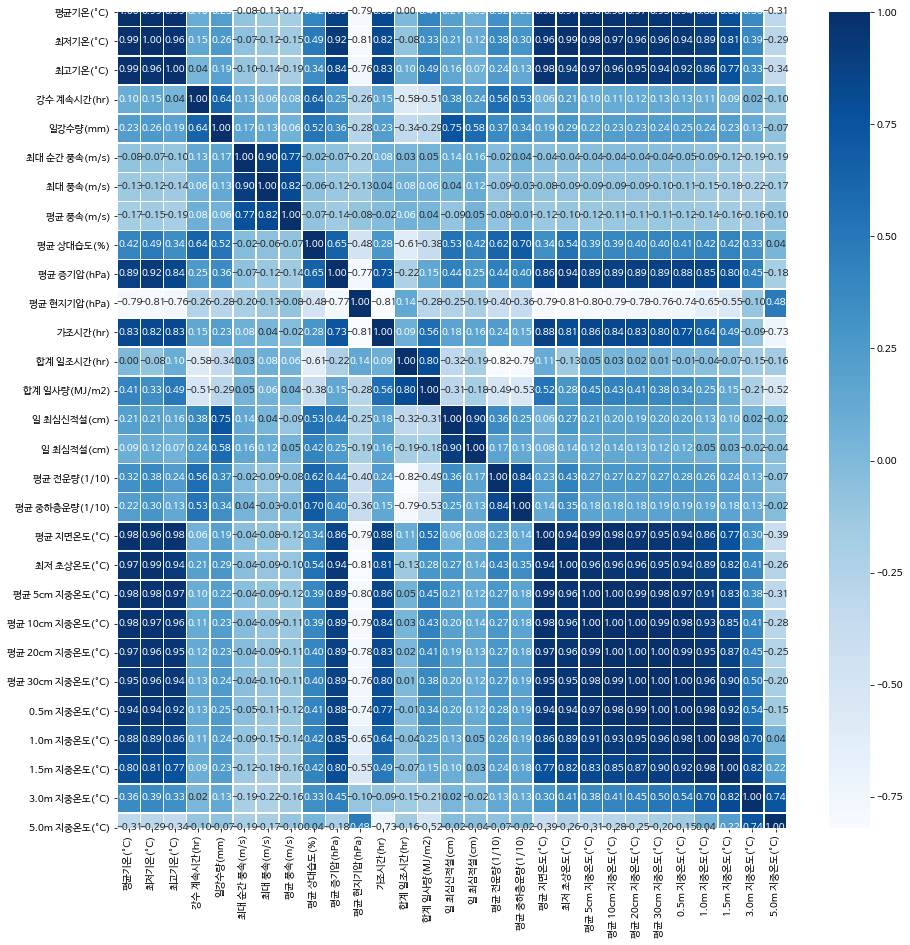

In [ ]:
#기본적으로 크게 상관없는 feature 제외
selected = ['날짜','요일', '주말', '노선명', '역명', '승차총승객수', '하차총승객수',
'평균기온(°C)', '최저기온(°C)','최고기온(°C)','강수 계속시간(hr)','일강수량(mm)',
'최대 순간 풍속(m/s)','최대 풍속(m/s)','평균 풍속(m/s)',
'평균 상대습도(%)','평균 증기압(hPa)', '평균 현지기압(hPa)',
'가조시간(hr)', '합계 일조시간(hr)',
'합계 일사량(MJ/m2)', '일 최심신적설(cm)','일 최심적설(cm)',
'평균 전운량(1/10)','평균 중하층운량(1/10)', '평균 지면온도(°C)', '최저 초상온도(°C)', '평균 5cm 지중온도(°C)',
'평균 10cm 지중온도(°C)', '평균 20cm 지중온도(°C)', '평균 30cm 지중온도(°C)',
'0.5m 지중온도(°C)', '1.0m 지중온도(°C)', '1.5m 지중온도(°C)', '3.0m 지중온도(°C)',
'5.0m 지중온도(°C)','일 미세먼지 농도(㎍/㎥)', '확진자수']

df_selected = df_all[selected]
df_selected

#상관계수를 확인할 feature
df_selceted_corr=df_selected[['평균기온(°C)', '최저기온(°C)', '최고기온(°C)','강수 계속시간(hr)', '일강수량(mm)', '최대 순간 풍속(m/s)', '최대 풍속(m/s)', '평균 풍속(m/s)', 
            '평균 상대습도(%)', '평균 증기압(hPa)', '평균 현지기압(hPa)','가조시간(hr)', '합계 일조시간(hr)', 
            '합계 일사량(MJ/m2)', '일 최심신적설(cm)', '일 최심적설(cm)','평균 전운량(1/10)', '평균 중하층운량(1/10)', 
            '평균 지면온도(°C)', '최저 초상온도(°C)', '평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)', 
            '평균 20cm 지중온도(°C)', '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)', '1.0m 지중온도(°C)', 
            '1.5m 지중온도(°C)','3.0m 지중온도(°C)', '5.0m 지중온도(°C)']]
df_selceted_corr = df_selceted_corr.corr()

plt.figure(figsize=(15,15))
sns.heatmap(data = df_selceted_corr, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues');

상관관계가 높은 컬럼은 중복되니 굳이 사용할 필요가 없으니 빼도록 한다.

'평균기온(°C)' 제외 : '최저기온(°C)', '최고기온(°C)' 과 0.99 상관

아래 11개의 특성은 기온데이터와 상관관계가 높고, 관측데이터로만 존재하여 실제 적용시 예측된 데이터가 없기에 제외하도록 한다.

'평균 지면온도(°C)', '최저 초상온도(°C)', '평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)', '평균 20cm 지중온도(°C)', '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)', '1.0m 지중온도(°C)', '1.5m 지중온도(°C)','3.0m 지중온도(°C)', '5.0m 지중온도(°C)'


### 2) feature engineering

In [ ]:
def engineering(df):
  selected = ['날짜','요일', '주말', '노선명', '역명', '승차총승객수', '하차총승객수',
  '최저기온(°C)','최고기온(°C)','강수 계속시간(hr)','일강수량(mm)',
  '최대 순간 풍속(m/s)','최대 풍속(m/s)','평균 풍속(m/s)',
  '평균 상대습도(%)','평균 증기압(hPa)', '평균 현지기압(hPa)',
  '가조시간(hr)', '합계 일조시간(hr)',
  '합계 일사량(MJ/m2)', '일 최심신적설(cm)','일 최심적설(cm)',
  '평균 전운량(1/10)','평균 중하층운량(1/10)','일 미세먼지 농도(㎍/㎥)', '확진자수']

  df = df[selected]

  #연,월 데이터 구분
  df['날짜'] = df['날짜'].apply(lambda _ : datetime.strptime(_,'%Y-%m-%d'))
  df['연도']= df['날짜'].dt.year
  df['월']= df['날짜'].dt.month

  #타겟변수
  df['승하차총승객수']=df['승차총승객수']+df['하차총승객수']
  df.drop(['승차총승객수','하차총승객수'],axis=1,inplace=True)

  #코로나 발생이전 이후
  df['코로나 이후'] = np.where((df['날짜'] >= '2020-01-24') , 1,0 )
 
  return df
  #feature 72 -> 28 감소

In [ ]:
df_engineered = engineering(df_all)
df_engineered

,날짜,요일,주말,노선명,역명,최저기온(°C),최고기온(°C),강수 계속시간(hr),일강수량(mm),최대 순간 풍속(m/s),최대 풍속(m/s),평균 풍속(m/s),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),가조시간(hr),합계 일조시간(hr),합계 일사량(MJ/m2),일 최심신적설(cm),일 최심적설(cm),평균 전운량(1/10),평균 중하층운량(1/10),일 미세먼지 농도(㎍/㎥),확진자수,연도,월,승하차총승객수,코로나 이후
0,2016-01-01,Friday,0,2호선,홍대입구,-3.3,4.0,NaN,NaN,5.6,3.5,1.6,73.0,4.8,1019.9,9.6,2.1,4.61,NaN,NaN,7.0,7.0,56,NaN,2016,1,127255.0,0
1,2016-01-01,Friday,0,2호선,강남,-3.3,4.0,NaN,NaN,5.6,3.5,1.6,73.0,4.8,1019.9,9.6,2.1,4.61,NaN,NaN,7.0,7.0,56,NaN,2016,1,77201.0,0
2,2016-01-01,Friday,0,2호선,시청,-3.3,4.0,NaN,NaN,5.6,3.5,1.6,73.0,4.8,1019.9,9.6,2.1,4.61,NaN,NaN,7.0,7.0,56,NaN,2016,1,16656.0,0
3,2016-01-02,Saturday,1,2호선,홍대입구,1.0,9.5,NaN,NaN,6.9,4.5,2.0,76.9,7.1,1012.0,9.6,3.6,4.50,NaN,NaN,7.8,7.1,42,NaN,2016,1,165072.0,0
4,2016-01-02,Saturday,1,2호선,강남,1.0,9.5,NaN,NaN,6.9,4.5,2.0,76.9,7.1,1012.0,9.6,3.6,4.50,NaN,NaN,7.8,7.1,42,NaN,2016,1,135990.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5479,2021-01-30,Saturday,1,2호선,강남,-8.1,5.2,4.5,0.5,8.1,4.8,2.5,60.0,3.3,1015.0,10.3,6.4,10.46,0.8,0.8,3.9,3.9,74,100.0,2021,1,97024.0,1
5480,2021-01-30,Saturday,1,2호선,홍대입구,-8.1,5.2,4.5,0.5,8.1,4.8,2.5,60.0,3.3,1015.0,10.3,6.4,10.46,0.8,0.8,3.9,3.9,74,100.0,2021,1,90673.0,1
5481,2021-01-31,Sunday,1,2호선,시청,-3.8,8.7,NaN,NaN,7.0,4.4,2.0,57.0,4.3,1015.5,10.3,6.7,10.92,NaN,NaN,4.8,3.8,75,109.0,2021,1,7637.0,1
5482,2021-01-31,Sunday,1,2호선,강남,-3.8,8.7,NaN,NaN,7.0,4.4,2.0,57.0,4.3,1015.5,10.3,6.7,10.92,NaN,NaN,4.8,3.8,75,109.0,2021,1,51441.0,1


## 1-4. 결측치 처리

### 1) '0'으로 채울 결측값
강수 계속시간(hr), 일강수량(mm), 일 최심신적설(cm), 일 최심적설(cm), 확진자수
데이터는 결측값이 0이라고 생각되어 0으로 처리


In [ ]:
#결측치 처리

df_engineered.fillna({'강수 계속시간(hr)':0, '일강수량(mm)':0,'일 최심신적설(cm)':0,'일 최심적설(cm)':0,'확진자수':0}, inplace=True)
df_engineered

,날짜,요일,주말,노선명,역명,최저기온(°C),최고기온(°C),강수 계속시간(hr),일강수량(mm),최대 순간 풍속(m/s),최대 풍속(m/s),평균 풍속(m/s),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),가조시간(hr),합계 일조시간(hr),합계 일사량(MJ/m2),일 최심신적설(cm),일 최심적설(cm),평균 전운량(1/10),평균 중하층운량(1/10),일 미세먼지 농도(㎍/㎥),확진자수,연도,월,승하차총승객수,코로나 이후
0,2016-01-01,Friday,0,2호선,홍대입구,-3.3,4.0,0.0,0.0,5.6,3.5,1.6,73.0,4.8,1019.9,9.6,2.1,4.61,0.0,0.0,7.0,7.0,56,0.0,2016,1,127255.0,0
1,2016-01-01,Friday,0,2호선,강남,-3.3,4.0,0.0,0.0,5.6,3.5,1.6,73.0,4.8,1019.9,9.6,2.1,4.61,0.0,0.0,7.0,7.0,56,0.0,2016,1,77201.0,0
2,2016-01-01,Friday,0,2호선,시청,-3.3,4.0,0.0,0.0,5.6,3.5,1.6,73.0,4.8,1019.9,9.6,2.1,4.61,0.0,0.0,7.0,7.0,56,0.0,2016,1,16656.0,0
3,2016-01-02,Saturday,1,2호선,홍대입구,1.0,9.5,0.0,0.0,6.9,4.5,2.0,76.9,7.1,1012.0,9.6,3.6,4.50,0.0,0.0,7.8,7.1,42,0.0,2016,1,165072.0,0
4,2016-01-02,Saturday,1,2호선,강남,1.0,9.5,0.0,0.0,6.9,4.5,2.0,76.9,7.1,1012.0,9.6,3.6,4.50,0.0,0.0,7.8,7.1,42,0.0,2016,1,135990.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5479,2021-01-30,Saturday,1,2호선,강남,-8.1,5.2,4.5,0.5,8.1,4.8,2.5,60.0,3.3,1015.0,10.3,6.4,10.46,0.8,0.8,3.9,3.9,74,100.0,2021,1,97024.0,1
5480,2021-01-30,Saturday,1,2호선,홍대입구,-8.1,5.2,4.5,0.5,8.1,4.8,2.5,60.0,3.3,1015.0,10.3,6.4,10.46,0.8,0.8,3.9,3.9,74,100.0,2021,1,90673.0,1
5481,2021-01-31,Sunday,1,2호선,시청,-3.8,8.7,0.0,0.0,7.0,4.4,2.0,57.0,4.3,1015.5,10.3,6.7,10.92,0.0,0.0,4.8,3.8,75,109.0,2021,1,7637.0,1
5482,2021-01-31,Sunday,1,2호선,강남,-3.8,8.7,0.0,0.0,7.0,4.4,2.0,57.0,4.3,1015.5,10.3,6.7,10.92,0.0,0.0,4.8,3.8,75,109.0,2021,1,51441.0,1


### 2) 미세먼지 결측값
미세먼지 측정 결측값은 서울내 다른 측정소의 값으로 대체한다. 서울에는 서울지점과 관악산지점 측정소가 있어서 관악산 지점 측정데이터를 불러와서 서울 데이터와 비교해보았다. 시각화와 요약통계를 보니 대체하여도 괜찮다고 생각되어 대체하였다.

#### (1) 미세먼지_관악산 데이터 불러오기

In [ ]:
#미세먼지 데이터 불러오기

df_mise_gwankak = pd.DataFrame(columns=['지점', '지점명', '일시', '일 미세먼지 농도(㎍/㎥)'])

for y in range(2016,2022):  # 연도 선택

    y = str(y)
    df_mise_gwankak_year = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/project2/미세먼지_관악산_'+y+'.csv',encoding='cp949')

    df_mise_gwankak = pd.concat([df_mise_gwankak,df_mise_gwankak_year])
 
df_mise_gwankak.head()

,지점,지점명,일시,일 미세먼지 농도(㎍/㎥)
0,116,관악산,2016-01-01,30
1,116,관악산,2016-01-02,32
2,116,관악산,2016-01-03,73
3,116,관악산,2016-01-04,59
4,116,관악산,2016-01-05,27


In [ ]:
df_mise_gwankak[df_mise_gwankak.duplicated(['일시'],keep=False)]

,지점,지점명,일시,일 미세먼지 농도(㎍/㎥)


#### (2) 측정소별 미세먼지 데이터 비교

In [ ]:
#시각화를 위한 merge

#미세먼지 데이터 합치기
df_mise_all = pd.merge(df_mise,df_mise_gwankak,on='일시',how='left')
df_mise_all.set_index('일시',inplace=True)

df_mise_all.drop(['지점_x','지점_y'],axis=1,inplace=True) # 불필요한 지점 컬럼 제거
df_mise_all.rename({'일 미세먼지 농도(㎍/㎥)_x':'일 미세먼지 농도(㎍/㎥)_서울','일 미세먼지 농도(㎍/㎥)_y':'일 미세먼지 농도(㎍/㎥)_관악산'},axis=1,inplace=True) # 컬럼명 변경
df_mise_all[['일 미세먼지 농도(㎍/㎥)_서울','일 미세먼지 농도(㎍/㎥)_관악산']]= df_mise_all[['일 미세먼지 농도(㎍/㎥)_서울','일 미세먼지 농도(㎍/㎥)_관악산']].apply(pd.to_numeric) # 농도 데이터 수치화
df_mise_all['농도차이']=df_mise_all['일 미세먼지 농도(㎍/㎥)_관악산']-df_mise_all['일 미세먼지 농도(㎍/㎥)_서울']
df_mise_all.describe()  # 서울과 관악산 측정값 통계 비교


,일 미세먼지 농도(㎍/㎥)_서울,일 미세먼지 농도(㎍/㎥)_관악산,농도차이
count,1669.000000,1443.000000,1443.000000
mean,42.022768,34.793486,-9.711019
std,22.158562,17.212558,11.966855
min,7.000000,7.000000,-78.000000
25%,28.000000,24.000000,-14.000000
50%,38.000000,31.000000,-8.000000
75%,51.000000,41.000000,-3.000000
max,199.000000,261.000000,79.000000


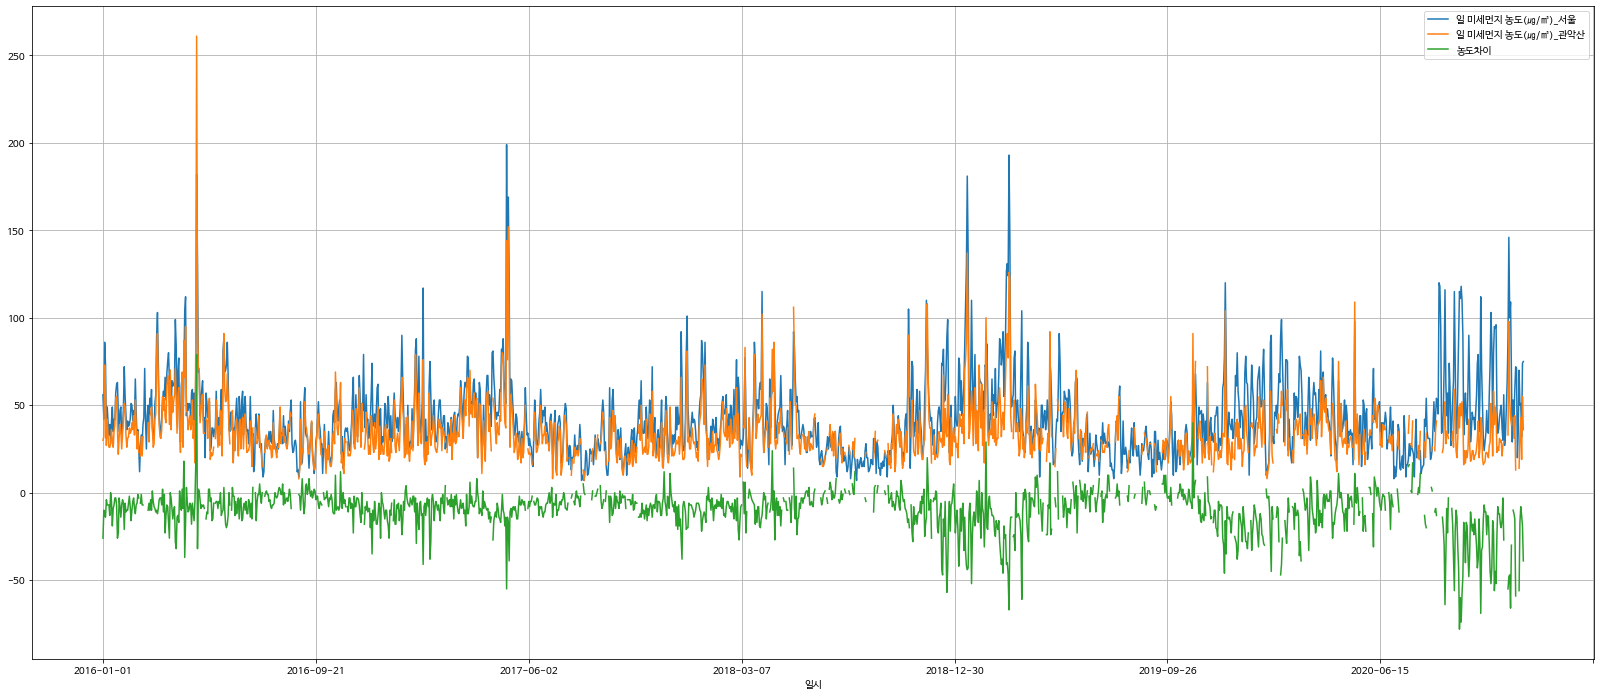

In [ ]:
#시각화

df_mise_all[['일 미세먼지 농도(㎍/㎥)_서울','일 미세먼지 농도(㎍/㎥)_관악산','농도차이']].plot(figsize=(28,12),grid=True);

#### (3)데이터 대체

In [ ]:
# selected 데이터에서 미세먼지 농도 결측값인 행의 날짜 추출
df_engineered = df_engineered.astype({'날짜':'str'})
df_mise_null = df_engineered[df_engineered['일 미세먼지 농도(㎍/㎥)'].isnull()][['날짜']]


# 미세먼지 농도 결측 날짜에 관악산 데이터 측정된 것 merge
df_mise_null = pd.merge(df_mise_null,df_mise_gwankak[['일시','일 미세먼지 농도(㎍/㎥)']],left_on='날짜',right_on='일시',how='left').drop('일시', axis=1)
df_mise_null['일 미세먼지 농도(㎍/㎥)']= df_mise_null['일 미세먼지 농도(㎍/㎥)'].apply(pd.to_numeric) # 농도 데이터 수치화

df_mise_null.rename({'일 미세먼지 농도(㎍/㎥)':'미세먼지 농도(보완)'},axis=1,inplace=True)
df_mise_null

#select 데이터에 관악산 데이터 추가
df_engineered = pd.merge(df_engineered,df_mise_null[['날짜','미세먼지 농도(보완)']],on='날짜',how='left')
df_engineered[df_engineered['일 미세먼지 농도(㎍/㎥)'].isnull()]

df_engineered.drop_duplicates(inplace=True)
df_engineered['미세먼지 농도(㎍/㎥)']=np.where(pd.notnull(df_engineered['일 미세먼지 농도(㎍/㎥)']) == True, df_engineered['일 미세먼지 농도(㎍/㎥)'], df_engineered['미세먼지 농도(보완)'])

df_engineered.drop(['일 미세먼지 농도(㎍/㎥)','미세먼지 농도(보완)'],axis=1,inplace=True) # 불필요한 지점 컬럼 제거
df_engineered['미세먼지 농도(㎍/㎥)']= df_engineered['미세먼지 농도(㎍/㎥)'].apply(pd.to_numeric) # 농도 데이터 수치화
df_engineered.reset_index(drop=True, inplace=True)

df_engineered.isnull().sum()
#미세먼지 결측값 543개 -> 246개로 감소

날짜                  0
요일                  0
주말                  0
노선명                 0
역명                  0
최저기온(°C)            0
최고기온(°C)            3
강수 계속시간(hr)         0
일강수량(mm)            0
최대 순간 풍속(m/s)       6
최대 풍속(m/s)          6
평균 풍속(m/s)          9
평균 상대습도(%)          0
평균 증기압(hPa)         0
평균 현지기압(hPa)        0
가조시간(hr)            0
합계 일조시간(hr)        33
합계 일사량(MJ/m2)      36
일 최심신적설(cm)         0
일 최심적설(cm)          0
평균 전운량(1/10)        0
평균 중하층운량(1/10)      0
확진자수                0
연도                  0
월                   0
승하차총승객수             0
코로나 이후              0
미세먼지 농도(㎍/㎥)      246
dtype: int64

## 1-5. 데이터 분할

분할하는 방법은 두가지를 생각하였다. 한가지는 시계열 데이터로 보고 과거데이터를 훈련데이터 최근데이터를 검증,테스트 데이터로 나누는 것이다. 2016년 부터 2021년까지 순서가 있으니 시계열 데이터로 분할 하는 것이 예측에 도움이 될 수 있을 것이라 생각하였다. 다른 한가지는 비시계열데이터로 분할한 것이다. 2020년부터 코로나가 발생하여 코로나 여부의 데이터가 편중되기 때문에 코로나 발생여부 데이터를 비례하여 분할 하는 것이 예측에 유리할 것이라고 생각하였다. 

후자의 방법을 선택하고 날짜를 연도와 월 feature로 분리하여 카디널리티를 낮추고 예측에 조금이라도 사용되도록 하였다.



In [ ]:
# 역 별로 데이터 분리
df_cityhall = df_engineered[df_engineered['역명']=='시청']
df_gangnam = df_engineered[df_engineered['역명']=='강남']
df_hongik = df_engineered[df_engineered['역명']=='홍대입구']
df_gangnam

,날짜,요일,주말,노선명,역명,최저기온(°C),최고기온(°C),강수 계속시간(hr),일강수량(mm),최대 순간 풍속(m/s),최대 풍속(m/s),평균 풍속(m/s),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),가조시간(hr),합계 일조시간(hr),합계 일사량(MJ/m2),일 최심신적설(cm),일 최심적설(cm),평균 전운량(1/10),평균 중하층운량(1/10),확진자수,연도,월,승하차총승객수,코로나 이후,미세먼지 농도(㎍/㎥)
1,2016-01-01,Friday,0,2호선,강남,-3.3,4.0,0.00,0.0,5.6,3.5,1.6,73.0,4.8,1019.9,9.6,2.1,4.61,0.0,0.0,7.0,7.0,0.0,2016,1,77201.0,0,56.0
4,2016-01-02,Saturday,1,2호선,강남,1.0,9.5,0.00,0.0,6.9,4.5,2.0,76.9,7.1,1012.0,9.6,3.6,4.50,0.0,0.0,7.8,7.1,0.0,2016,1,135990.0,0,42.0
7,2016-01-03,Sunday,1,2호선,강남,5.1,9.4,0.00,0.0,5.7,4.0,1.8,80.6,7.7,1008.9,9.7,2.2,4.85,0.0,0.0,7.5,7.5,0.0,2016,1,95759.0,0,86.0
10,2016-01-04,Monday,0,2호선,강남,-2.5,5.3,0.00,0.0,8.6,5.1,3.1,54.4,3.9,1013.1,9.7,8.6,9.03,0.0,0.0,4.4,2.5,0.0,2016,1,254731.0,0,73.0
13,2016-01-05,Tuesday,0,2호선,강남,-4.8,1.5,0.00,0.0,7.3,4.6,2.3,39.4,1.9,1016.9,9.7,7.9,8.22,0.0,0.0,3.4,0.1,0.0,2016,1,256237.0,0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,2021-01-27,Wednesday,0,2호선,강남,-1.8,6.5,0.00,0.0,9.0,5.2,2.2,47.6,3.2,1012.9,10.2,8.4,12.40,0.0,0.0,6.4,0.0,104.0,2021,1,151399.0,1,50.0
5473,2021-01-28,Thursday,0,2호선,강남,-9.7,1.4,1.33,2.0,17.5,8.7,4.0,52.3,2.8,1006.5,10.2,2.3,6.14,3.6,3.6,5.1,3.3,113.0,2021,1,147908.0,1,51.0
5476,2021-01-29,Friday,0,2호선,강남,-11.6,-4.9,0.00,0.0,13.7,7.3,3.5,40.0,1.3,1015.6,10.3,9.6,14.42,0.0,0.7,0.3,0.3,152.0,2021,1,153459.0,1,32.0
5479,2021-01-30,Saturday,1,2호선,강남,-8.1,5.2,4.50,0.5,8.1,4.8,2.5,60.0,3.3,1015.0,10.3,6.4,10.46,0.8,0.8,3.9,3.9,100.0,2021,1,97024.0,1,74.0


In [ ]:
# train,test set은 코로나 여부가 골고루 나누어지도록 분할한다.
# 데이터수가 1828로 적기 때문에 교차검증을 활용한다.
gangnam_train, gangnam_test = train_test_split(df_gangnam, test_size=0.2, random_state=777, stratify=df_gangnam['코로나 이후'])
gangnam_train, gangnam_val = train_test_split(gangnam_train, test_size=0.2, random_state=777, stratify=gangnam_train['코로나 이후'])
print(gangnam_train.shape)
print(gangnam_val.shape)
print(gangnam_test.shape)

(1169, 28)
(293, 28)
(366, 28)


In [ ]:
# 타겟변수 아닌 코로나 이후 데이터의 비율
gangnam_train['코로나 이후'].value_counts(normalize=True)
# gangnam_val['코로나 이후'].value_counts(normalize=True)
# gangnam_test['코로나 이후'].value_counts(normalize=True)

0    0.811805
1    0.188195
Name: 코로나 이후, dtype: float64

In [ ]:
#훈련데이터 타입
gangnam_train.dtypes
#날짜는 훈련에 포함시키지 않는다.
#역명과 노선명은 1개뿐 이므로 제외한다.
#요일은 ordinal ecoding으로 처리한다.

날짜                 object
요일                 object
주말                  int64
노선명                object
역명                 object
최저기온(°C)          float64
최고기온(°C)          float64
강수 계속시간(hr)       float64
일강수량(mm)          float64
최대 순간 풍속(m/s)     float64
최대 풍속(m/s)        float64
평균 풍속(m/s)        float64
평균 상대습도(%)        float64
평균 증기압(hPa)       float64
평균 현지기압(hPa)      float64
가조시간(hr)          float64
합계 일조시간(hr)       float64
합계 일사량(MJ/m2)     float64
일 최심신적설(cm)       float64
일 최심적설(cm)        float64
평균 전운량(1/10)      float64
평균 중하층운량(1/10)    float64
확진자수              float64
연도                  int64
월                   int64
승하차총승객수           float64
코로나 이후              int64
미세먼지 농도(㎍/㎥)      float64
dtype: object

In [ ]:
# 훈련데이터 결측값
gangnam_train.isnull().sum()
# 결측값은 모두 평균값으로 대체한다. simpleimputer로 한다.

날짜                 0
요일                 0
주말                 0
노선명                0
역명                 0
최저기온(°C)           0
최고기온(°C)           1
강수 계속시간(hr)        0
일강수량(mm)           0
최대 순간 풍속(m/s)      0
최대 풍속(m/s)         0
평균 풍속(m/s)         0
평균 상대습도(%)         0
평균 증기압(hPa)        0
평균 현지기압(hPa)       0
가조시간(hr)           0
합계 일조시간(hr)        8
합계 일사량(MJ/m2)      8
일 최심신적설(cm)        0
일 최심적설(cm)         0
평균 전운량(1/10)       0
평균 중하층운량(1/10)     0
확진자수               0
연도                 0
월                  0
승하차총승객수            0
코로나 이후             0
미세먼지 농도(㎍/㎥)      57
dtype: int64

# 2. 모델링

## 2-1. 모델 선택

모델은 회귀모델로 하는 것이 좋을 것 같다. 타겟변수의 기준을 정하고 어느값보다 크다 작다의 예측보다 대략적으로 어느정도 수치로 나타나는 것이 유용할 것이라고 생각한다.

In [ ]:
target = '승하차총승객수'
features = gangnam_train.drop(columns=[target,'날짜','역명','노선명']).columns

In [ ]:
y_gangnam_train = gangnam_train[target]
X_gangnam_train = gangnam_train[features]

y_gangnam_val = gangnam_val[target]
X_gangnam_val = gangnam_val[features]

y_gangnam_test = gangnam_test[target]
X_gangnam_test = gangnam_test[features]

### 1) 기준모델

#### (1) 강남역 데이터

189452.0752780154

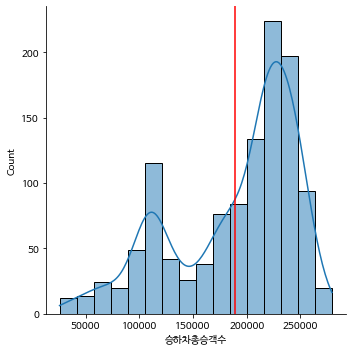

In [ ]:
# 기준모델
sns.displot(y_gangnam_train,kde=True);
plt.axvline(y_gangnam_train.mean(), color='red');
y_gangnam_train.mean()

쌍봉우리 형태를 나타내어 주말여부를 구분하여 분포를 살펴보았다.

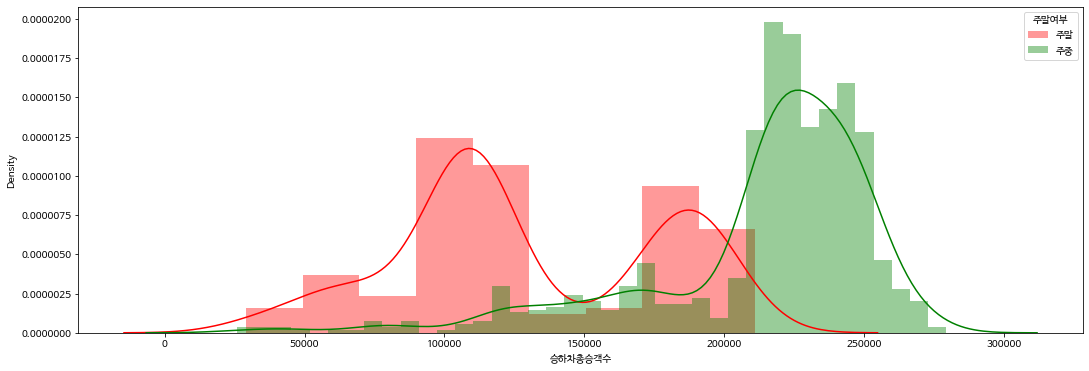

In [ ]:
plt.figure(figsize=(18, 6))

sns.distplot(gangnam_train[gangnam_train.주말 == 1]["승하차총승객수"], color="red", label="주말")
sns.distplot(gangnam_train[gangnam_train.주말 == 0]["승하차총승객수"], color="green", label="주중")

plt.legend(title="주말여부")
plt.show()

주말에서 쌍봉우리 형태가 나와서 요일로 구분해보았다.

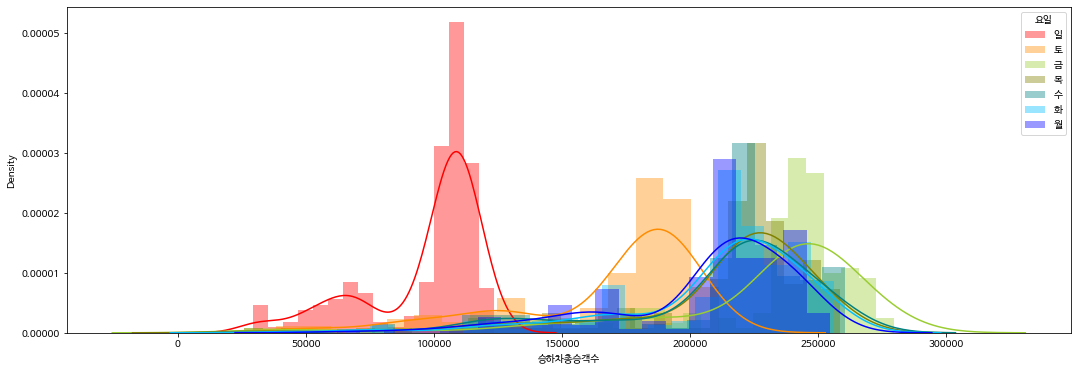

In [ ]:
plt.figure(figsize=(18, 6))

sns.distplot(gangnam_train[gangnam_train.요일 == 'Sunday']["승하차총승객수"], color="red", label="일")
sns.distplot(gangnam_train[gangnam_train.요일 == 'Saturday']["승하차총승객수"], color="darkorange", label="토")
sns.distplot(gangnam_train[gangnam_train.요일 == 'Friday']["승하차총승객수"], color="yellowgreen", label="금")
sns.distplot(gangnam_train[gangnam_train.요일 == 'Thursday']["승하차총승객수"], color="olive", label="목")
sns.distplot(gangnam_train[gangnam_train.요일 == 'Wednesday']["승하차총승객수"], color="teal", label="수")
sns.distplot(gangnam_train[gangnam_train.요일 == 'Tuesday']["승하차총승객수"], color="deepskyblue", label="화")
sns.distplot(gangnam_train[gangnam_train.요일 == 'Monday']["승하차총승객수"], color="blue", label="월")

plt.legend(title="요일")
plt.show()

토요일과 일요일에 따라서 쌍봉우리 형태가 나온다. 토요일은 주중데이터와 비교했을 때 조금 작은수치였지만, 일요일은 값이 절반정도로 작다. 주말여부가 데이터 예측모델의 많은부분을 차지할 것 같다. 주말데이터를 제외하고 주중데이터로만 모델을 돌려보았다.

#### (2) 강남역 주중데이터

(834, 28)
(209, 28)
(261, 28)


212169.49040767387

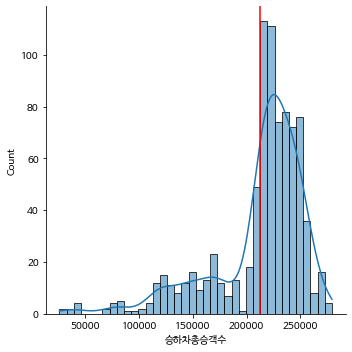

In [ ]:
#주중데이터만 추출
df_gangnamweek = df_gangnam[df_gangnam['주말']==0]
gangnamweek_train, gangnamweek_test = train_test_split(df_gangnamweek, test_size=0.2, random_state=777, stratify=df_gangnamweek['코로나 이후'])
gangnamweek_train, gangnamweek_val = train_test_split(gangnamweek_train, test_size=0.2, random_state=777, stratify=gangnamweek_train['코로나 이후'])

target = '승하차총승객수'
features = gangnamweek_train.drop(columns=[target,'날짜','역명','노선명','주말']).columns # 주말이 없으므로 주말제외
# features = gangnamweek_train.drop(columns=[target,'날짜','역명','노선명','주말','코로나 이후']).columns # 코로나 이후 확진자 데이터와 겹치니 제거

print(gangnamweek_train.shape)
print(gangnamweek_val.shape)
print(gangnamweek_test.shape)

y_gangnamweek_train = gangnamweek_train[target]
X_gangnamweek_train = gangnamweek_train[features]
y_gangnamweek_val = gangnamweek_val[target]
X_gangnamweek_val = gangnamweek_val[features]
y_gangnamweek_test = gangnamweek_test[target]
X_gangnamweek_test = gangnamweek_test[features]

sns.displot(y_gangnamweek_train,kde=True);
plt.axvline(y_gangnamweek_train.mean(), color='red');
y_gangnamweek_train.mean()

왼쪽으로 꼬리가 긴 형태여서 변환하지 않고 진행하였다.

In [ ]:
X_gangnamweek_train.isnull().sum()

요일                 0
최저기온(°C)           0
최고기온(°C)           1
강수 계속시간(hr)        0
일강수량(mm)           0
최대 순간 풍속(m/s)      1
최대 풍속(m/s)         1
평균 풍속(m/s)         2
평균 상대습도(%)         0
평균 증기압(hPa)        0
평균 현지기압(hPa)       0
가조시간(hr)           0
합계 일조시간(hr)        6
합계 일사량(MJ/m2)      4
일 최심신적설(cm)        0
일 최심적설(cm)         0
평균 전운량(1/10)       0
평균 중하층운량(1/10)     0
확진자수               0
연도                 0
월                  0
코로나 이후             0
미세먼지 농도(㎍/㎥)      41
dtype: int64

### 2) selectKBest

#### (1) 강남역 데이터

1 features
Selected names:  Index(['요일_Sunday'], dtype='object')
Test MAE: 30,539
Test R2: 0.4309496426641015 

2 features
Selected names:  Index(['요일_Sunday', '주말'], dtype='object')
Test MAE: 27,402
Test R2: 0.48968385030093764 

3 features
Selected names:  Index(['요일_Sunday', '주말', '코로나 이후'], dtype='object')
Test MAE: 16,765
Test R2: 0.7184652631824047 

4 features
Selected names:  Index(['요일_Sunday', '주말', '확진자수', '코로나 이후'], dtype='object')
Test MAE: 15,658
Test R2: 0.731585674459011 

5 features
Selected names:  Index(['요일_Sunday', '주말', '확진자수', '연도', '코로나 이후'], dtype='object')
Test MAE: 15,649
Test R2: 0.7319429288827649 

6 features
Selected names:  Index(['요일_Friday', '요일_Sunday', '주말', '확진자수', '연도', '코로나 이후'], dtype='object')
Test MAE: 14,377
Test R2: 0.7410050036566542 

7 features
Selected names:  Index(['요일_Friday', '요일_Sunday', '요일_Thursday', '주말', '확진자수', '연도', '코로나 이후'], dtype='object')
Test MAE: 14,339
Test R2: 0.7424306760164309 

8 features
Selected names:  Index(['요일_

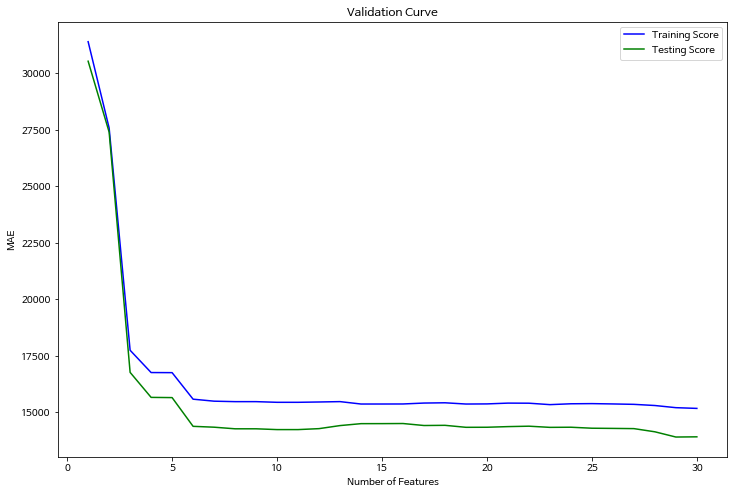

In [ ]:
# feature selection
# selectKBest

#요일 원핫인코딩
encoder = OneHotEncoder(use_cat_names = True)
X_gangnam_train = encoder.fit_transform(X_gangnam_train)
X_gangnam_val = encoder.transform(X_gangnam_val)

#결측치
imputer = SimpleImputer() 
X_gangnam_train_imputed = imputer.fit_transform(X_gangnam_train)
X_gangnam_val_imputed = imputer.transform(X_gangnam_val)

training = []
testing = []
ks = range(1, len(X_gangnam_train.columns)+1)

# 1 부터 특성 수 만큼 사용한 모델을 만들어서 MAE 값을 비교 합니다.
for k in range(1, len(X_gangnam_train.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_gangnam_train_imputed, y_gangnam_train)
    X_val_selected = selector.transform(X_gangnam_val_imputed)
    
    all_names = X_gangnam_train.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, y_gangnam_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(y_gangnam_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_val_selected)
    mae = mean_absolute_error(y_gangnam_val, y_pred)
    r2 = r2_score(y_gangnam_val, y_pred)
    testing.append(mae)
    print(f'Test MAE: {mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.figure(figsize=(12, 8))
plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()


feature 의 갯수는 6개로 사용하는 것이 가장 효율적이다. 10개를 넘어가면서부터는 feature가 증가함에도 오차의 정도가 늘어가는 경우도 발생했다. 6개의 feature는 '요일_Friday', '요일_Sunday', '주말', '확진자수', '연도', '코로나 이후' 이었다.
요일과 관련된 feature가 많이 나온 것 같아. 원핫인코딩이 아닌 ordinal encoding으로 실행해 보았다. 

1 features
Selected names:  Index(['요일_Sunday'], dtype='object')
Test MAE: 30,539
Test R2: 0.4309496426641015 

2 features
Selected names:  Index(['요일_Sunday', '주말'], dtype='object')
Test MAE: 27,402
Test R2: 0.48968385030093764 

3 features
Selected names:  Index(['요일_Sunday', '주말', '코로나 이후'], dtype='object')
Test MAE: 16,765
Test R2: 0.7184652631824047 

4 features
Selected names:  Index(['요일_Sunday', '주말', '확진자수', '코로나 이후'], dtype='object')
Test MAE: 15,658
Test R2: 0.731585674459011 

5 features
Selected names:  Index(['요일_Sunday', '주말', '확진자수', '연도', '코로나 이후'], dtype='object')
Test MAE: 15,649
Test R2: 0.7319429288827649 

6 features
Selected names:  Index(['요일_Friday', '요일_Sunday', '주말', '확진자수', '연도', '코로나 이후'], dtype='object')
Test MAE: 14,377
Test R2: 0.7410050036566542 

7 features
Selected names:  Index(['요일_Friday', '요일_Sunday', '요일_Thursday', '주말', '확진자수', '연도', '코로나 이후'], dtype='object')
Test MAE: 14,339
Test R2: 0.7424306760164309 

8 features
Selected names:  Index(['요일_

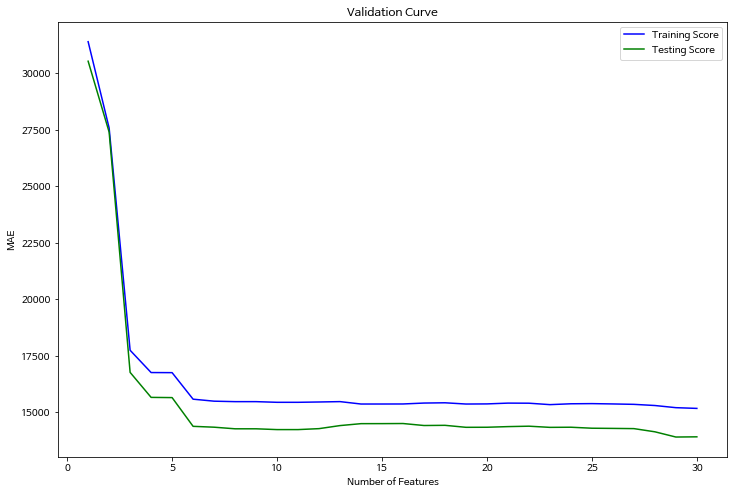

In [ ]:

#요일 순차형 인코딩
encoder = OrdinalEncoder()
X_gangnam_train = encoder.fit_transform(X_gangnam_train)
X_gangnam_val = encoder.transform(X_gangnam_val)

#결측치
imputer = SimpleImputer() 
X_gangnam_train_imputed = imputer.fit_transform(X_gangnam_train)
X_gangnam_val_imputed = imputer.transform(X_gangnam_val)

training = []
testing = []
ks = range(1, len(X_gangnam_train.columns)+1)

# 1 부터 특성 수 만큼 사용한 모델을 만들어서 MAE 값을 비교 합니다.
for k in range(1, len(X_gangnam_train.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_gangnam_train_imputed, y_gangnam_train)
    X_val_selected = selector.transform(X_gangnam_val_imputed)
    
    all_names = X_gangnam_train.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, y_gangnam_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(y_gangnam_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_val_selected)
    mae = mean_absolute_error(y_gangnam_val, y_pred)
    r2 = r2_score(y_gangnam_val, y_pred)
    testing.append(mae)
    print(f'Test MAE: {mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.figure(figsize=(12, 8))
plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()


요일은 순차형 인코딩으로 하니 원핫인코딩으로 한것만큼 오차가 감소하지 못했고, 주요한 feature 도 5개미만에서 결정되었다. 요일 인코딩은 원핫인코딩으로 하는 것이 좋을 것 같다.

날씨와 관련된 feature에는 어떤 것이 상관관계가 높은지 살펴보니 가장 먼저 나온 것은 '평균 상대습도(%)' 였고, 다음은 '합계 일조시간(hr)'이다. 이것이 비오는 날과 더운 여름날로 해석하긴 어려울 것 같다. '일강수량(mm)'은 16번째에서 등장하였고, '최고기온(°C)'은 23번째에서 등장하였다. '평균 상대습도(%)' 와 '합계 일조시간(hr)' 데이터의 의미를 확인해볼 필요가 있다.

효율적인 예측보다는 모든 특성들의 영향을 확인해보고 싶으므로 특성은 전체를 이용하여 진행한다.

#### (2) 강남역 주중데이터

1 features
Selected names:  Index(['코로나 이후'], dtype='object')
Test MAE: 22,176
Test R2: 0.19792552635172667 

2 features
Selected names:  Index(['확진자수', '코로나 이후'], dtype='object')
Test MAE: 20,912
Test R2: 0.24654649037503784 

3 features
Selected names:  Index(['확진자수', '연도', '코로나 이후'], dtype='object')
Test MAE: 20,948
Test R2: 0.24106685129675132 

4 features
Selected names:  Index(['평균 풍속(m/s)', '확진자수', '연도', '코로나 이후'], dtype='object')
Test MAE: 20,977
Test R2: 0.23824539438214043 

5 features
Selected names:  Index(['요일_Friday', '평균 풍속(m/s)', '확진자수', '연도', '코로나 이후'], dtype='object')
Test MAE: 18,645
Test R2: 0.29342273957145915 

6 features
Selected names:  Index(['요일_Friday', '최대 풍속(m/s)', '평균 풍속(m/s)', '확진자수', '연도', '코로나 이후'], dtype='object')
Test MAE: 18,663
Test R2: 0.29460555416020096 

7 features
Selected names:  Index(['요일_Monday', '요일_Friday', '최대 풍속(m/s)', '평균 풍속(m/s)', '확진자수', '연도',
       '코로나 이후'],
      dtype='object')
Test MAE: 18,292
Test R2: 0.2952516950387982 

8 fe

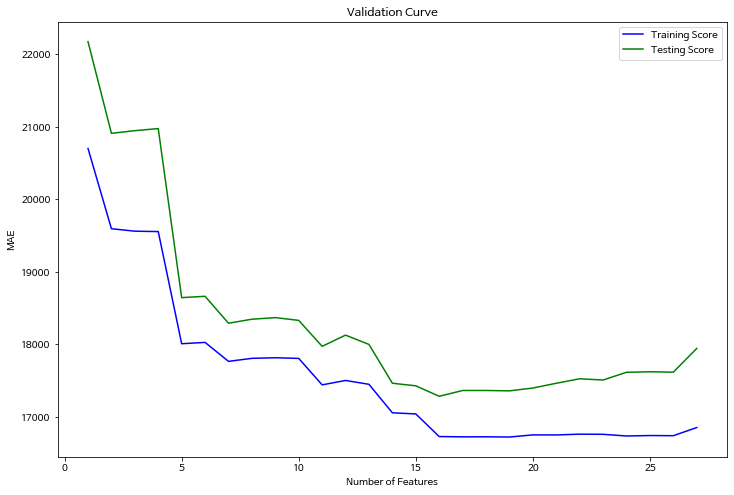

In [ ]:
# feature selection
# selectKBest

#요일 원핫인코딩
encoder = OneHotEncoder(use_cat_names = True)
X_gangnamweek_train = encoder.fit_transform(X_gangnamweek_train)
X_gangnamweek_val = encoder.transform(X_gangnamweek_val)

#결측치
imputer = SimpleImputer() 
X_gangnamweek_train_imputed = imputer.fit_transform(X_gangnamweek_train)
X_gangnamweek_val_imputed = imputer.transform(X_gangnamweek_val)

training = []
testing = []
ks = range(1, len(X_gangnamweek_train.columns)+1)

# 1 부터 특성 수 만큼 사용한 모델을 만들어서 MAE 값을 비교 합니다.
for k in range(1, len(X_gangnamweek_train.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_gangnamweek_train_imputed, y_gangnamweek_train)
    X_val_selected = selector.transform(X_gangnamweek_val_imputed)
    
    all_names = X_gangnamweek_train.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model_lr = LinearRegression()
    model_lr.fit(X_train_selected, y_gangnamweek_train)
    y_pred = model_lr.predict(X_train_selected)
    mae = mean_absolute_error(y_gangnamweek_train, y_pred)
    training.append(mae)
    
    y_pred = model_lr.predict(X_val_selected)
    mae = mean_absolute_error(y_gangnamweek_val, y_pred)
    r2 = r2_score(y_gangnamweek_val, y_pred)
    testing.append(mae)
    print(f'Test MAE: {mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.figure(figsize=(12, 8))
plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()


### 3) 다중선형회귀모델

#### (1) 강남역 데이터

훈련데이터 mae: 48176.49
검증데이터 mae: 45618.59


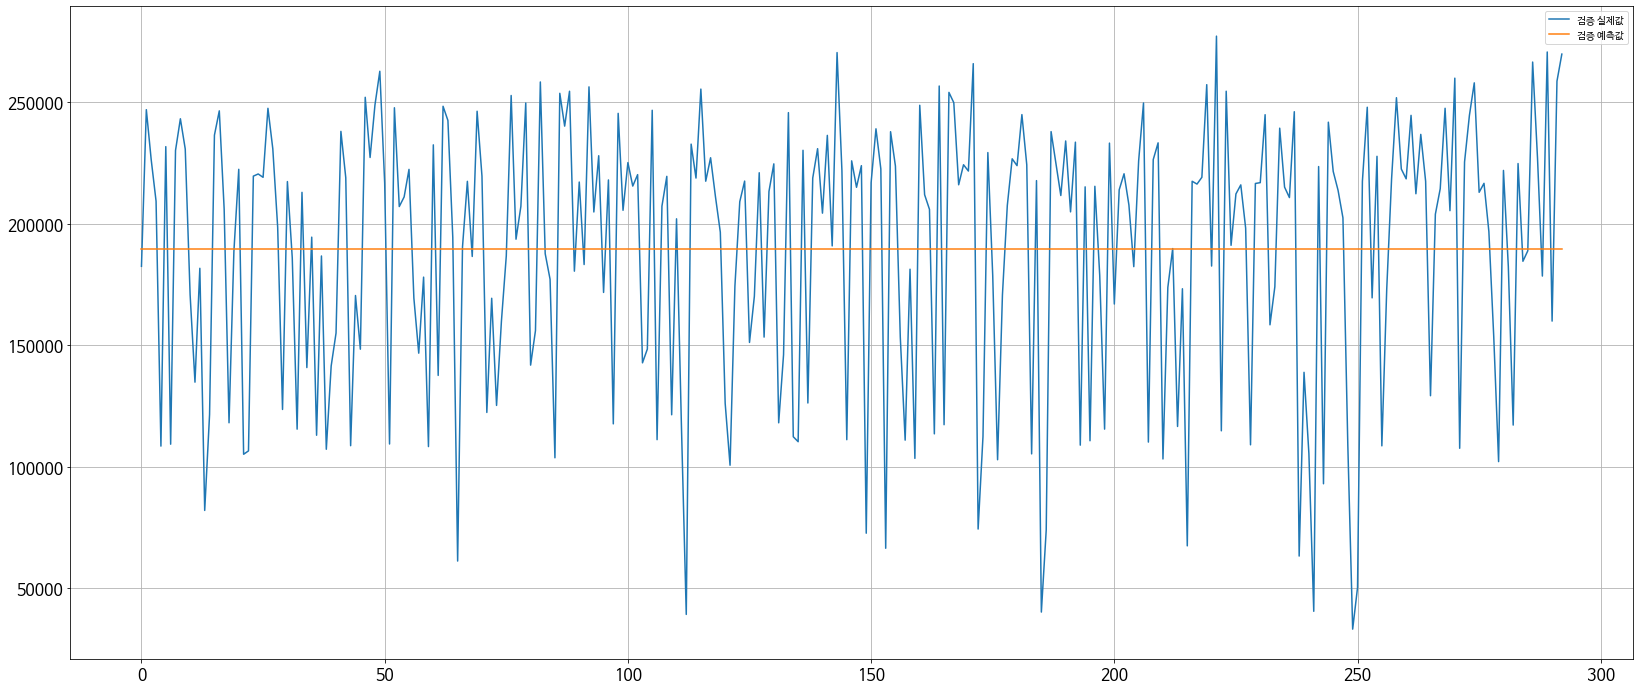

In [ ]:
# 기준모델
predict = y_gangnam_train.mean()
y_pred = [predict] * len(y_gangnam_train)
mae = mean_absolute_error(y_gangnam_train, y_pred)

print(f'훈련데이터 mae: {mae:.2f}')

# 테스트 에러(MAE)
y_pred = [predict] * len(y_gangnam_val)
mae = mean_absolute_error(y_gangnam_val, y_pred)
print(f'검증데이터 mae: {mae:.2f}')

df_visual = pd.DataFrame({'검증 실제값':y_gangnam_val,'검증 예측값':y_pred})
df_visual.reset_index(inplace=True)

df_visual[['검증 실제값','검증 예측값']].plot(figsize=(28,12),grid=True,fontsize=16)

타겟분포가 쌍봉우리 형태여서 그런지 기준모델(평균)으로 예측하니 엄청나게 틀리다.

In [ ]:
# 다중선형회귀모델 
model = LinearRegression(n_jobs=-1)

encoder = OneHotEncoder(use_cat_names = True) #원핫인코딩
imputer = SimpleImputer() # 결측치
scaler = StandardScaler() # 표준화

# 훈련데이터 fit
X_gangnam_train = encoder.fit_transform(X_gangnam_train) 
X_gangnam_train_imputed = imputer.fit_transform(X_gangnam_train)
X_gangnam_train_scaled = scaler.fit_transform(X_gangnam_train_imputed)

# 검증데이터 변형
X_gangnam_val = encoder.transform(X_gangnam_val)
X_gangnam_val_imputed = imputer.transform(X_gangnam_val)
X_gangnam_val_scaled = scaler.transform(X_gangnam_val_imputed)

model.fit(X_gangnam_train_scaled, y_gangnam_train)
y_pred = model.predict(X_gangnam_val_scaled)
mae = mean_absolute_error(y_gangnam_val, y_pred)
r2 = r2_score(y_gangnam_val, y_pred)

print(f'mae: {mae:.2f}')
print(f'r2: {r2:.6f}')


mae: 14058.36
r2: 0.757070


In [ ]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names = True), 
    SimpleImputer(), 
    StandardScaler(), 
    LinearRegression(n_jobs=-1)
)

pipe.fit(X_gangnam_train, y_gangnam_train)

print('검증세트 정확도', pipe.score(X_gangnam_val, y_gangnam_val))  #파이프라인에서 r2 값이 나오는 것 같다. mae 값으로 비교하고 싶은데 방법을 모르겠다. mae값이 해석이 직관적이어서 좋다.

# y_pred = pipe.predict(X_test)


검증세트 정확도 0.7570697557190276


In [ ]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names = True), 
    SimpleImputer(), 
    StandardScaler(), 
    LinearRegression(n_jobs=-1)
)

pipe.fit(X_gangnam_train, y_gangnam_train)

k = 2
scores = cross_val_score(pipe, X_gangnam_train, y_gangnam_train, cv=k, 
                         scoring='neg_mean_absolute_error')
                        #  scoring='r2')

print(f'MAE ({k} folds):', scores)
-scores.mean()


MAE (2 folds): [-16098.49251522 -16075.5926356 ]


16087.042575408932

In [ ]:
#교차검증

pipe = make_pipeline(
    OneHotEncoder(use_cat_names = True), 
    SimpleImputer(), 
    StandardScaler(), 
    LinearRegression(n_jobs=-1)
)

# 3-fold 교차검증을 수행합니다.
k = 3
scores = cross_val_score(pipe, X_gangnam_train, y_gangnam_train, cv=k, 
                         scoring='neg_mean_absolute_error')
                        #  scoring='r2')

print(f'MAE ({k} folds):', scores)
-scores.mean()
# 3-fold 교차검증에서는 교차검증하지않았을 때보다 에러가 늘었다.

MAE (3 folds): [-16525.67369119 -13429.86954394 -17643.23829898]


15866.26051137073

Ridge Regression, alpha=0
Test MAE: 13,912
Test R2: 0.758


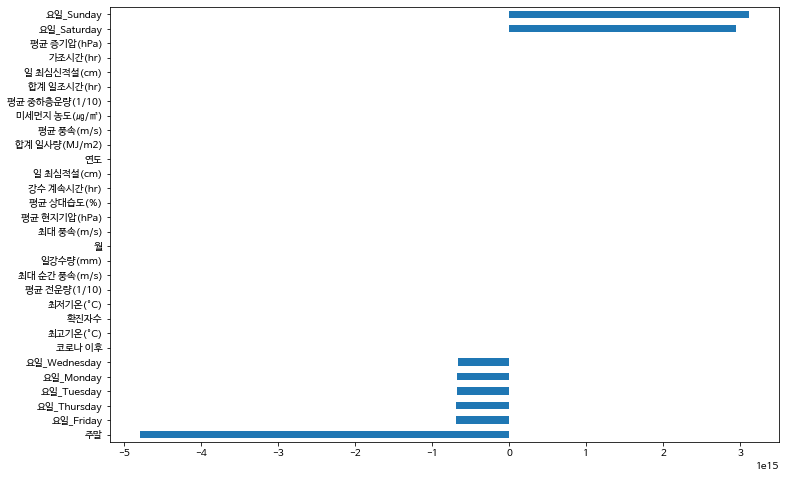

Ridge Regression, alpha=0.001
Test MAE: 13,914
Test R2: 0.758


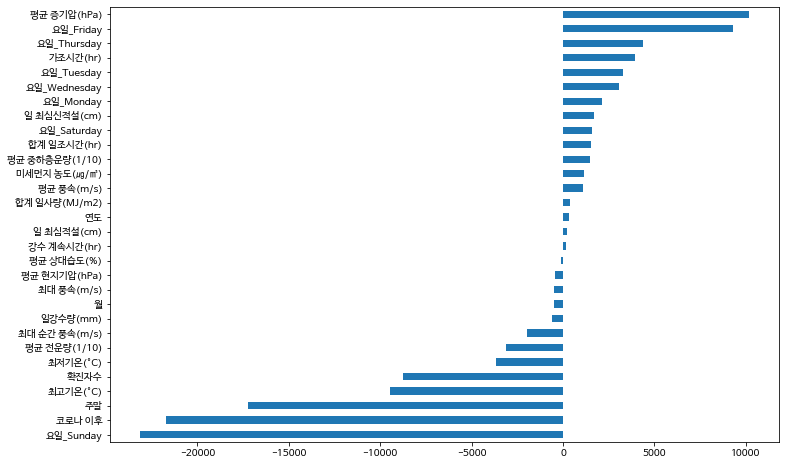

Ridge Regression, alpha=0.01
Test MAE: 13,931
Test R2: 0.757


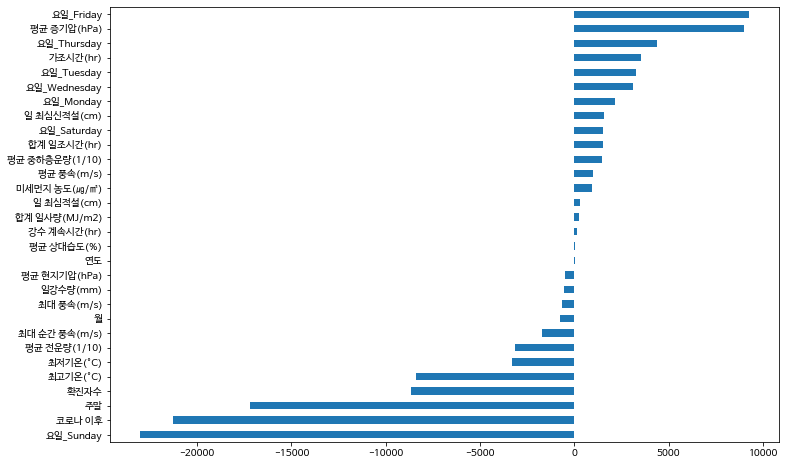

Ridge Regression, alpha=0.02
Test MAE: 13,965
Test R2: 0.756


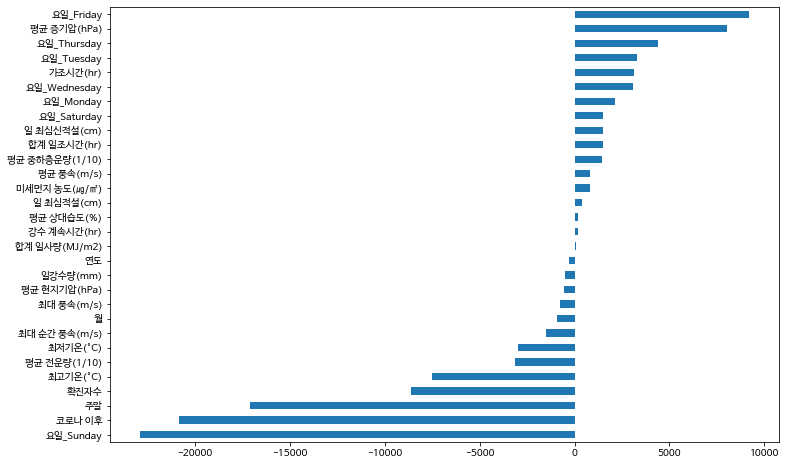

Ridge Regression, alpha=0.03
Test MAE: 14,015
Test R2: 0.755


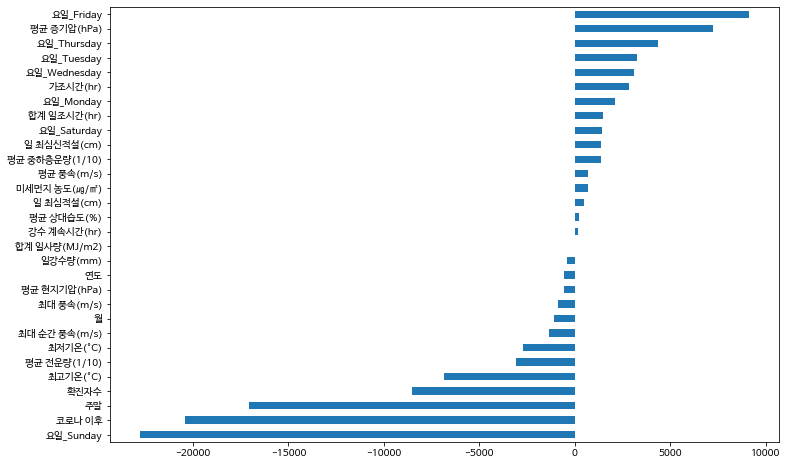

Ridge Regression, alpha=0.04
Test MAE: 14,066
Test R2: 0.754


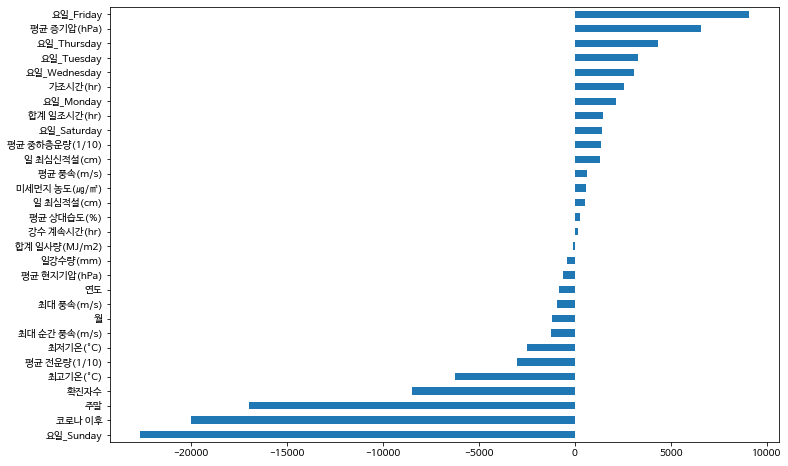

Ridge Regression, alpha=0.05
Test MAE: 14,120
Test R2: 0.753


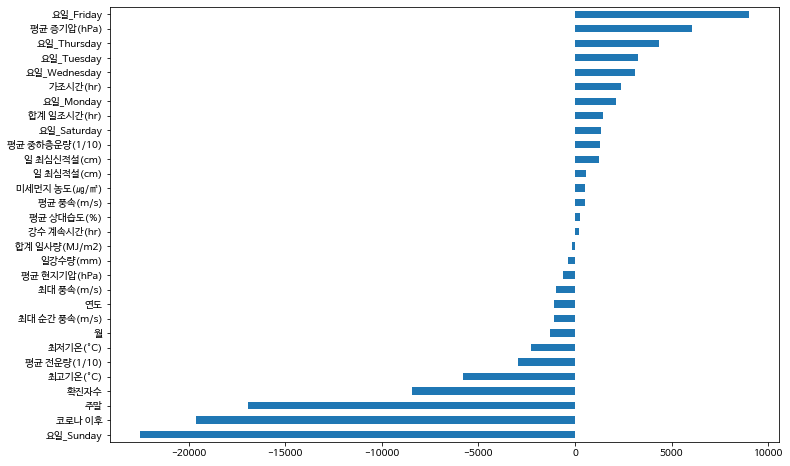

Ridge Regression, alpha=0.1
Test MAE: 14,449
Test R2: 0.749


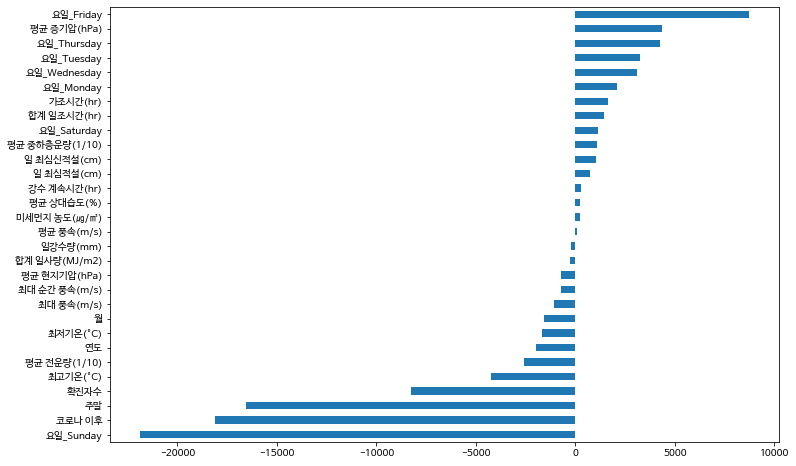

Ridge Regression, alpha=0.2
Test MAE: 15,304
Test R2: 0.740


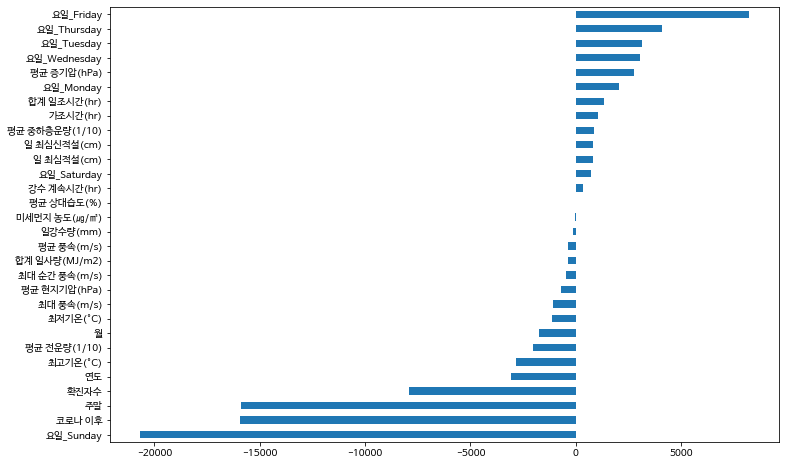

Ridge Regression, alpha=1.0
Test MAE: 22,342
Test R2: 0.657


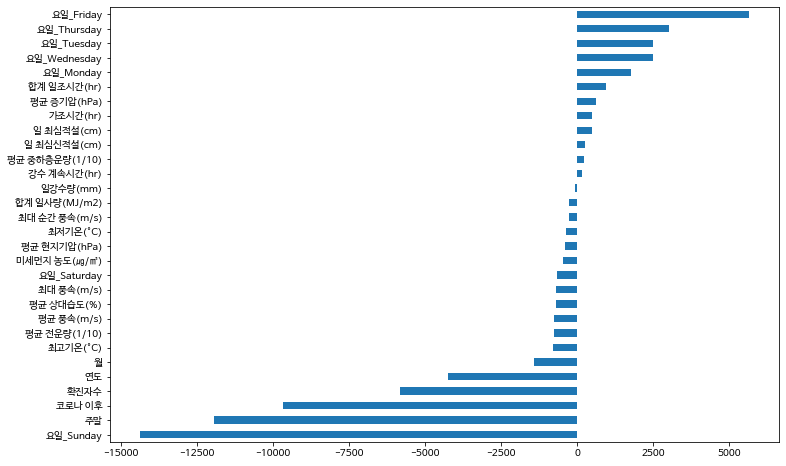

In [ ]:
# 릿지cv

encoder = OneHotEncoder(use_cat_names = True)
imputer = SimpleImputer()
scaler = StandardScaler()

# 훈련데이터 fit
X_gangnam_train = encoder.fit_transform(X_gangnam_train) 
X_gangnam_train_imputed = imputer.fit_transform(X_gangnam_train)
X_gangnam_train_scaled = scaler.fit_transform(X_gangnam_train_imputed)

# 검증데이터 변형
X_gangnam_val = encoder.transform(X_gangnam_val)
X_gangnam_val_imputed = imputer.transform(X_gangnam_val)
X_gangnam_val_scaled = scaler.transform(X_gangnam_val_imputed)


for alpha in [0, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 1.0]:
      
  print(f'Ridge Regression, alpha={alpha}')

  # Ridge 모델 학습
  model = Ridge(alpha=alpha, normalize=True)  
  model.fit(X_gangnam_train_scaled, y_gangnam_train)
  y_pred = model.predict(X_gangnam_val_scaled)

  # MAE for test
  mae = mean_absolute_error(y_gangnam_val, y_pred)
  r2 = r2_score(y_gangnam_val, y_pred)
  
  print(f'Test MAE: {mae:,.0f}')
  print(f'Test R2: {r2:,.3f}')
  
  # plot coefficients
  coefficients = pd.Series(model.coef_, X_gangnam_train.columns)
  plt.figure(figsize=(12,8))
  coefficients.sort_values().plot.barh()
  plt.show()

#### (2) 강남역 주중데이터

훈련데이터 mae: 31097
검증데이터 mae: 28309
검증데이터 mae: 30607


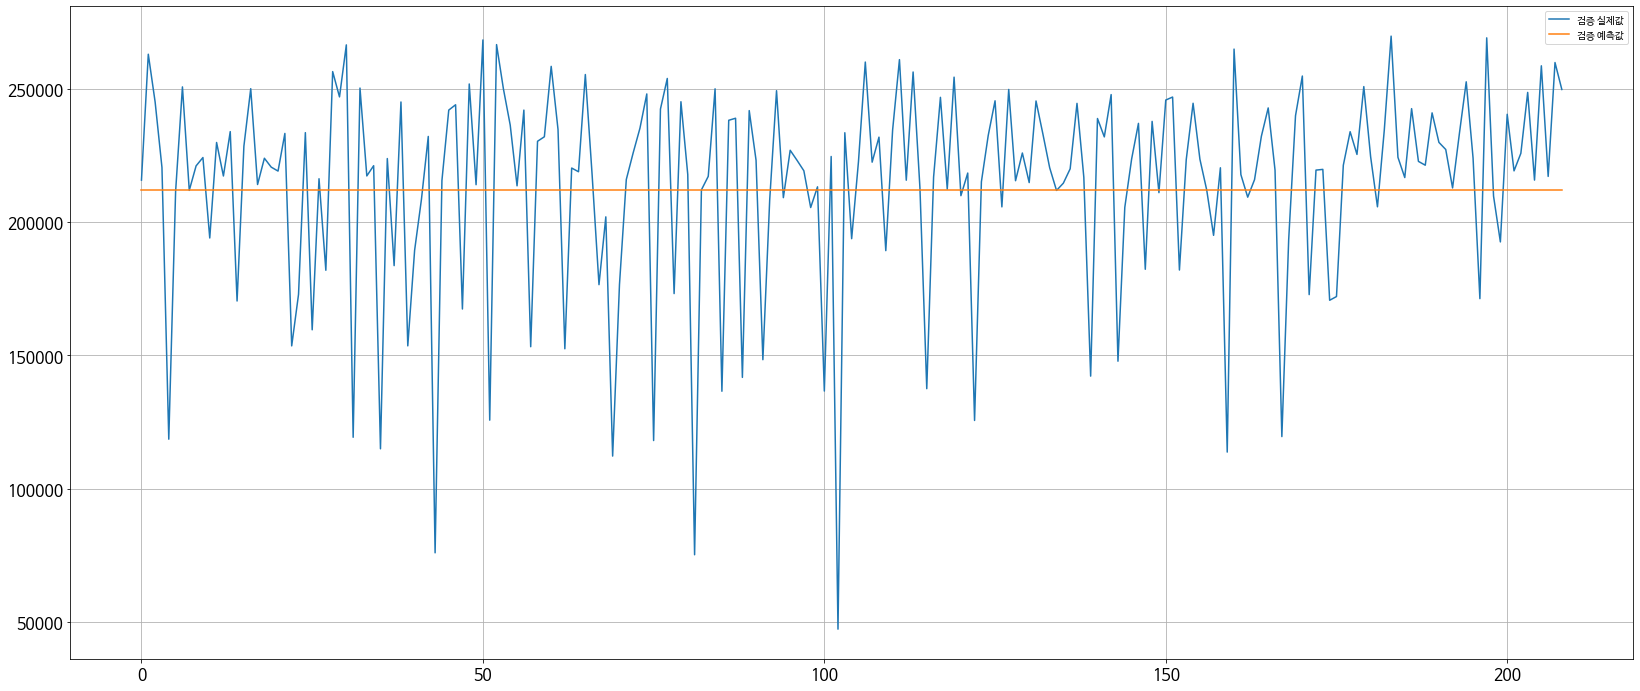

In [ ]:
# 기준모델
predict = y_gangnamweek_train.mean()
y_pred = [predict] * len(y_gangnamweek_train)
mae = mean_absolute_error(y_gangnamweek_train, y_pred)

print(f'훈련데이터 mae: {mae:.0f}')

# 검증 에러(MAE)
y_pred = [predict] * len(y_gangnamweek_val)
mae = mean_absolute_error(y_gangnamweek_val, y_pred)
print(f'검증데이터 mae: {mae:.0f}')


df_visual = pd.DataFrame({'검증 실제값':y_gangnamweek_val,'검증 예측값':y_pred})
df_visual.reset_index(inplace=True)

df_visual[['검증 실제값','검증 예측값']].plot(figsize=(28,12),grid=True,fontsize=16)

# 검증 에러(MAE)
y_pred = [predict] * len(y_gangnamweek_test)
mae = mean_absolute_error(y_gangnamweek_test, y_pred)
print(f'검증데이터 mae: {mae:.0f}')

훈련데이터 mae: 17904
검증데이터 mae: 19129
r2: 0.280450
테스트 데이터 mae: 19490


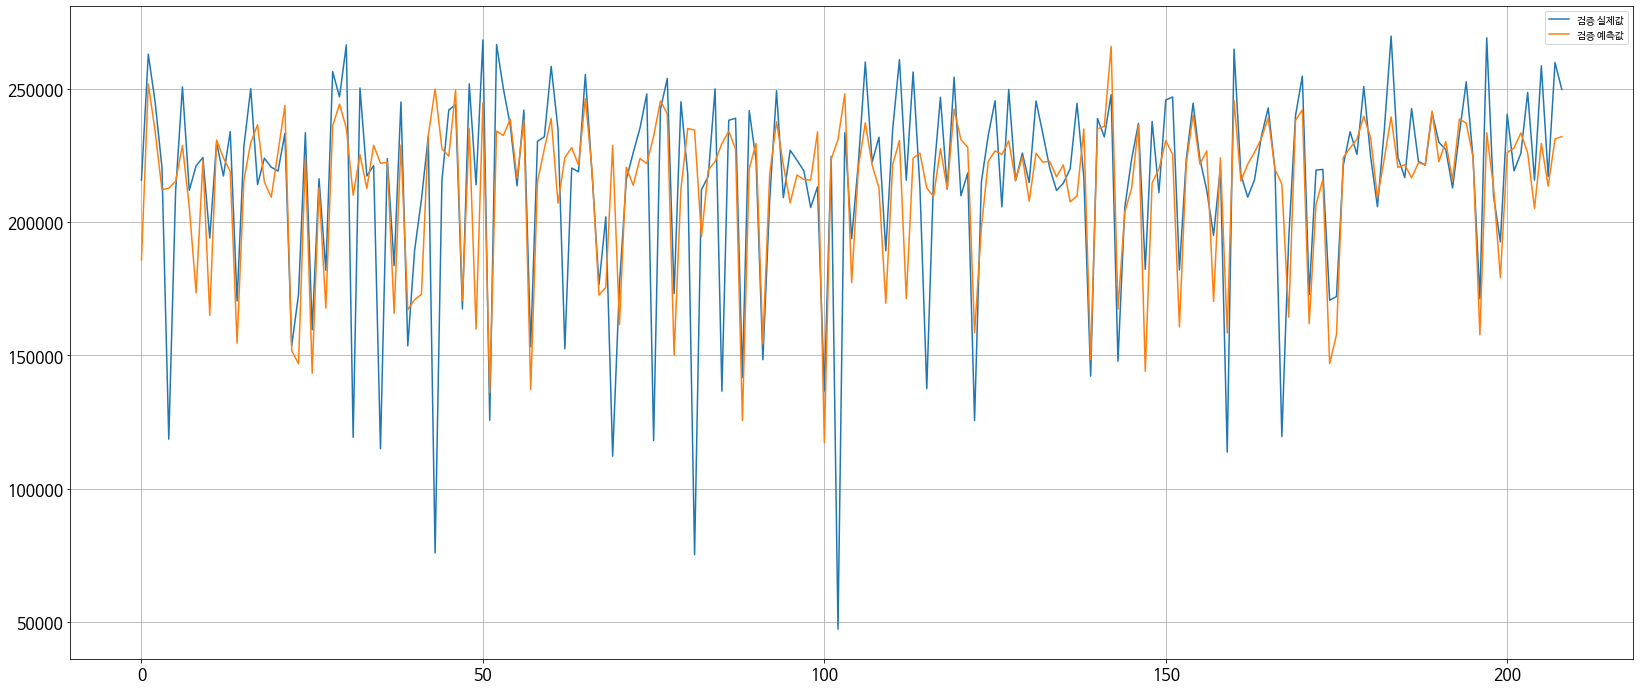

In [ ]:
# 다중선형회귀모델 
model_lr = LinearRegression(n_jobs=-1)

encoder = OrdinalEncoder() #순차인코딩
imputer = SimpleImputer() # 결측치
scaler = StandardScaler() # 표준화

# 훈련데이터 fit
X_gangnamweek_train = encoder.fit_transform(X_gangnamweek_train) 
X_gangnamweek_train_imputed = imputer.fit_transform(X_gangnamweek_train)
X_gangnamweek_train_scaled = scaler.fit_transform(X_gangnamweek_train_imputed)

# 검증데이터 변형
X_gangnamweek_val = encoder.transform(X_gangnamweek_val)
X_gangnamweek_val_imputed = imputer.transform(X_gangnamweek_val)
X_gangnamweek_val_scaled = scaler.transform(X_gangnamweek_val_imputed)

# 검증데이터 변형
X_gangnamweek_test = encoder.transform(X_gangnamweek_test)
X_gangnamweek_test_imputed = imputer.transform(X_gangnamweek_test)
X_gangnamweek_test_scaled = scaler.transform(X_gangnamweek_test_imputed)

model_lr.fit(X_gangnamweek_train_scaled, y_gangnamweek_train)

y_pred = model_lr.predict(X_gangnamweek_train_scaled)
mae = mean_absolute_error(y_gangnamweek_train, y_pred)
r2 = r2_score(y_gangnamweek_train, y_pred)
print(f'훈련데이터 mae: {mae:.0f}')


y_pred = model_lr.predict(X_gangnamweek_val_scaled)
mae = mean_absolute_error(y_gangnamweek_val, y_pred)
r2 = r2_score(y_gangnamweek_val, y_pred)
print(f'검증데이터 mae: {mae:.0f}')
print(f'r2: {r2:.6f}')

df_visual = pd.DataFrame({'검증 실제값':y_gangnamweek_val,'검증 예측값':y_pred})
df_visual.reset_index(inplace=True)

df_visual[['검증 실제값','검증 예측값']].plot(figsize=(28,12),grid=True,fontsize=16)

y_pred = model_lr.predict(X_gangnamweek_test_scaled)
mae = mean_absolute_error(y_gangnamweek_test, y_pred)
# r2 = r2_score(y_gangnamweek_val, y_pred)
print(f'테스트 데이터 mae: {mae:.0f}')
# print(f'r2: {r2:.6f}')



In [ ]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names = True), 
    SimpleImputer(), 
    StandardScaler(), 
    LinearRegression(n_jobs=-1)
)

pipe.fit(X_gangnamweek_train, y_gangnamweek_train)

print('검증세트 정확도', pipe.score(X_gangnamweek_val, y_gangnamweek_val))  #파이프라인에서 r2 값이 나오는 것 같다. mae 값으로 비교하고 싶은데 방법을 모르겠다. mae값이 해석이 직관적이어서 좋다.

# y_pred = pipe.predict(X_test)


검증세트 정확도 0.28045016222655317


In [ ]:
#교차검증 한번 해보았다. 뒤에서 하이퍼파라미터 조정할 때 더 해볼 예정

pipe = make_pipeline(
    OneHotEncoder(use_cat_names = True), 
    SimpleImputer(), 
    StandardScaler(), 
    LinearRegression(n_jobs=-1)
)

# 3-fold 교차검증을 수행합니다.
k = 3
scores = cross_val_score(pipe, X_gangnamweek_train, y_gangnamweek_train, cv=k, 
                         scoring='neg_mean_absolute_error')
                        #  scoring='r2')

print(f'훈련데이터 MAE ({k} folds):', scores)
print(f'평균:',-scores.mean())

scores = cross_val_score(pipe, X_gangnamweek_val, y_gangnamweek_val, cv=k, 
                         scoring='neg_mean_absolute_error')
                        #  scoring='r2')

print(f'\n검증데이터 MAE ({k} folds):', scores)
print(f'평균:',-scores.mean())
# 주중데이터에서는 3-fold 교차검증을 하니 오차가 조금 줄었다.

훈련데이터 MAE (3 folds): [-19356.69847789 -18866.88597404 -17775.79987508]
평균: 18666.4614423359

검증데이터 MAE (3 folds): [-23060.91730324 -23628.44616435 -17050.43303629]
평균: 21246.598834627523


Ridge Regression, alpha=0
Test MAE: 19,129
Test R2: 0.280


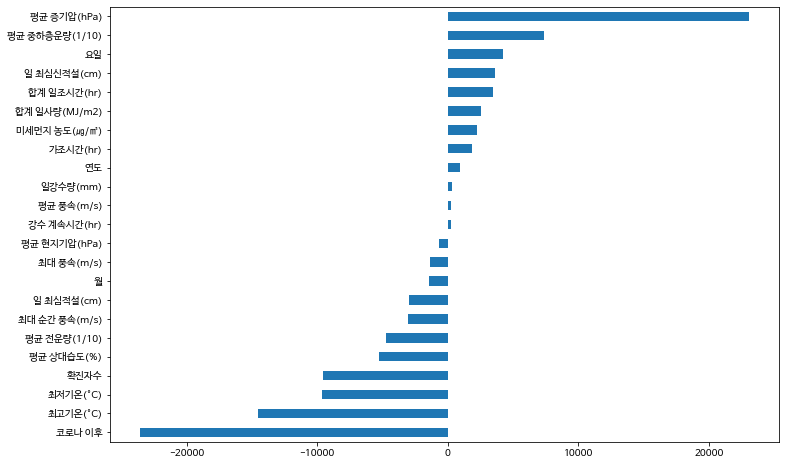

Ridge Regression, alpha=0.001
Test MAE: 19,104
Test R2: 0.281


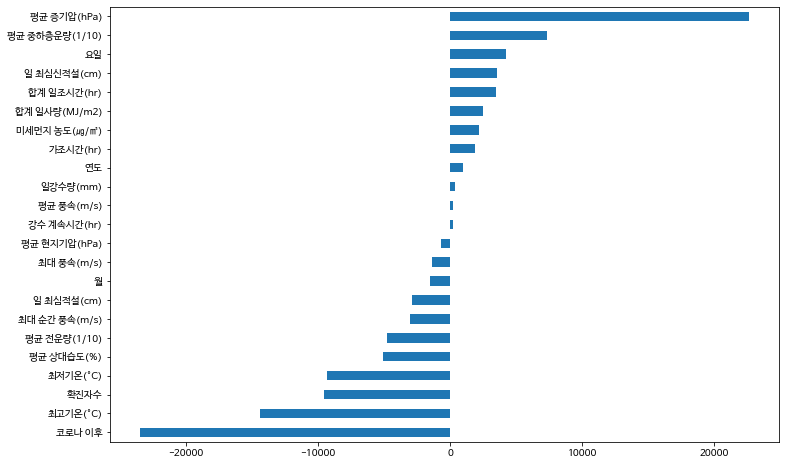

Ridge Regression, alpha=0.01
Test MAE: 18,952
Test R2: 0.288


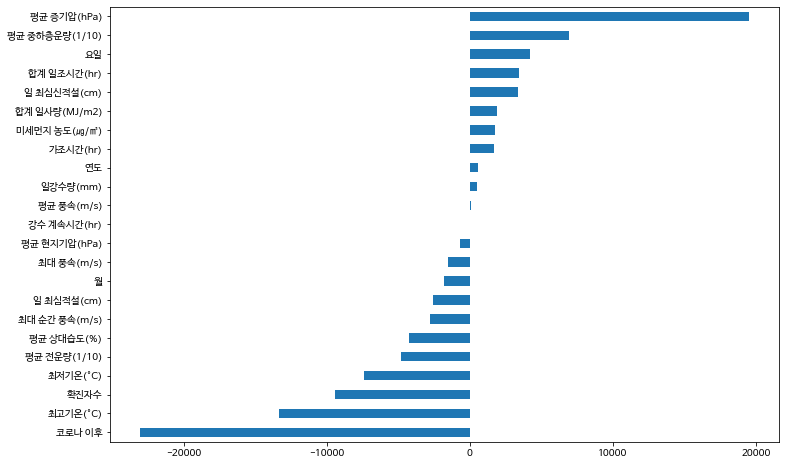

Ridge Regression, alpha=0.05
Test MAE: 18,801
Test R2: 0.300


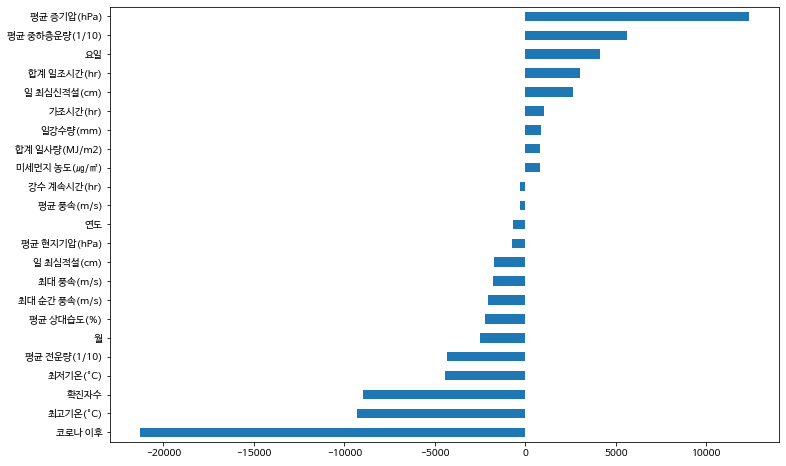

Ridge Regression, alpha=0.06
Test MAE: 18,817
Test R2: 0.302


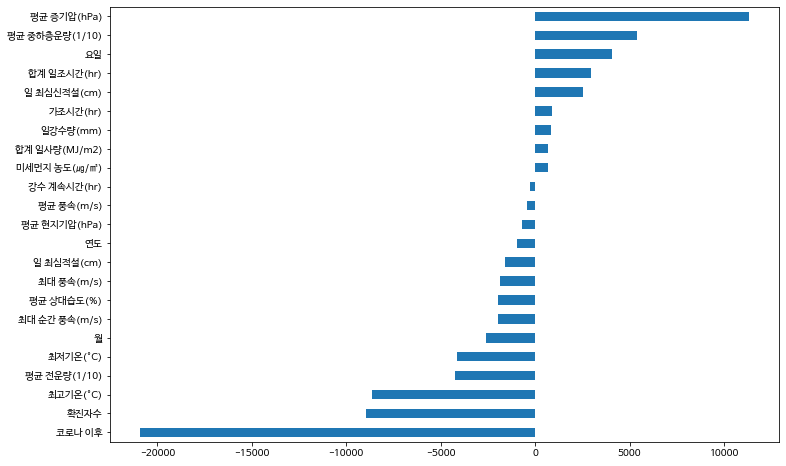

Ridge Regression, alpha=0.07
Test MAE: 18,830
Test R2: 0.303


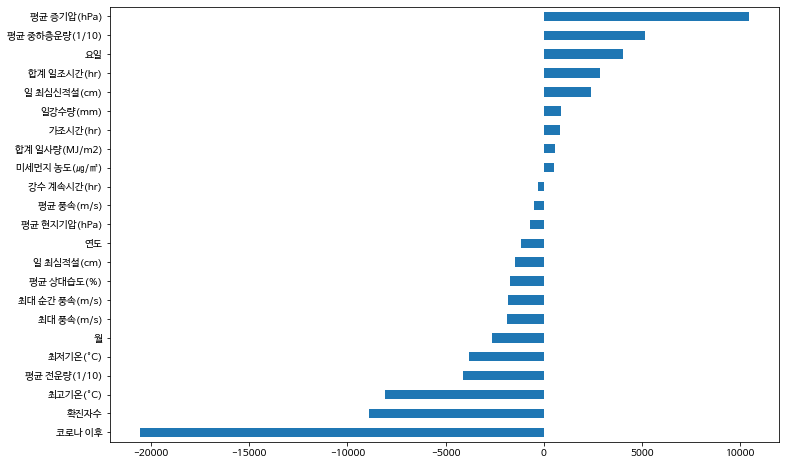

Ridge Regression, alpha=0.08
Test MAE: 18,841
Test R2: 0.304


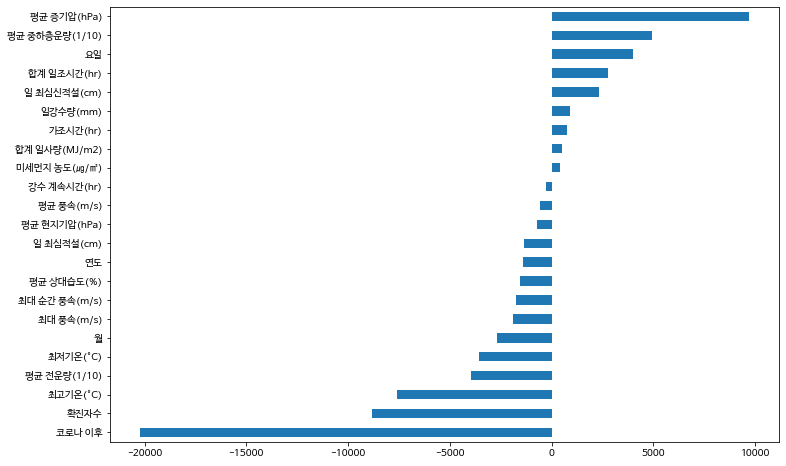

Ridge Regression, alpha=0.1
Test MAE: 18,872
Test R2: 0.306


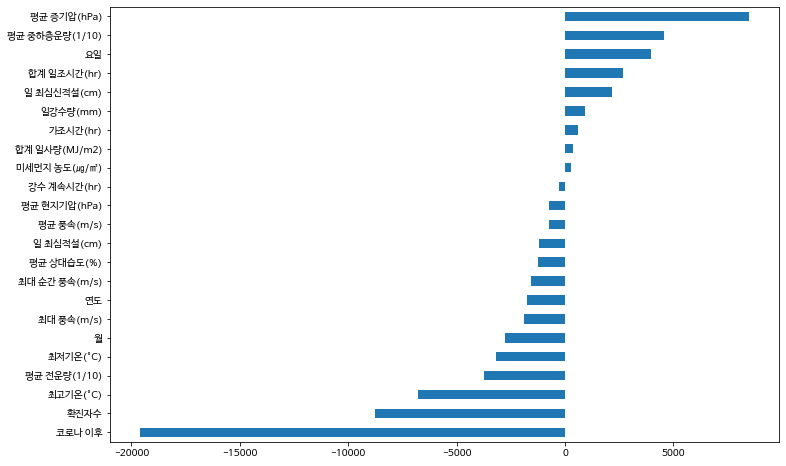

Ridge Regression, alpha=0.2
Test MAE: 19,001
Test R2: 0.310


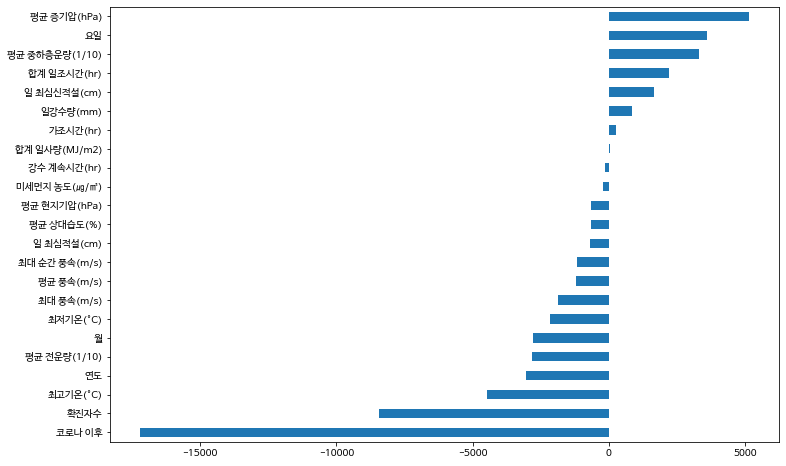

Ridge Regression, alpha=1.0
Test MAE: 20,607
Test R2: 0.285


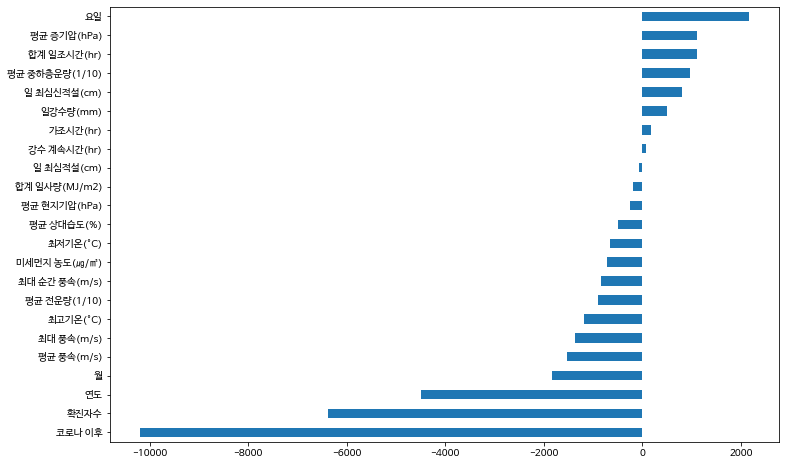

In [ ]:
# 릿지cv 한번 해보았다. 하이퍼파라미터 참고용


encoder = OneHotEncoder(use_cat_names = True)
imputer = SimpleImputer()
scaler = StandardScaler()

# 훈련데이터 fit
X_gangnamweek_train = encoder.fit_transform(X_gangnamweek_train) 
X_gangnamweek_train_imputed = imputer.fit_transform(X_gangnamweek_train)
X_gangnamweek_train_scaled = scaler.fit_transform(X_gangnamweek_train_imputed)

# 검증데이터 변형
X_gangnamweek_val = encoder.transform(X_gangnamweek_val)
X_gangnamweek_val_imputed = imputer.transform(X_gangnamweek_val)
X_gangnamweek_val_scaled = scaler.transform(X_gangnamweek_val_imputed)


for alpha in [0, 0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 1.0]:
      
  print(f'Ridge Regression, alpha={alpha}')

  # Ridge 모델 학습
  model_rg = Ridge(alpha=alpha, normalize=True)  
  model_rg.fit(X_gangnamweek_train_scaled, y_gangnamweek_train)
  y_pred = model_rg.predict(X_gangnamweek_val_scaled)

  # MAE for test
  mae = mean_absolute_error(y_gangnamweek_val, y_pred)
  r2 = r2_score(y_gangnamweek_val, y_pred)
  
  print(f'Test MAE: {mae:,.0f}')
  print(f'Test R2: {r2:,.3f}')
  
  # plot coefficients
  coefficients = pd.Series(model_rg.coef_, X_gangnamweek_train.columns)
  plt.figure(figsize=(12,8))
  coefficients.sort_values().plot.barh()
  plt.show()

주중데이터에서는 람다값이 예측에 도움을 주었다. 람다 = 0.06, 0.07 에서 가장 적은 mae를 보였다.



### 3) Hyperparameter tuning

#### (1) 강남역 데이터

In [ ]:
# Hyperparameter tuning
for i in range(2,20,3):
  pipe = make_pipeline(
      OneHotEncoder(use_cat_names=True)
      , SimpleImputer()
      , StandardScaler()
      , SelectKBest(f_regression)
      , Ridge()
  )

  # 튜닝할 하이퍼파라미터의 범위를 지정해 주는 부분
  dists = {
      'simpleimputer__strategy': ['mean', 'median'], 
      'selectkbest__k': range(1, len(X_gangnam_train.columns)+1), 
      'ridge__alpha': [0,0.01, 0.05, 0.06,0.07,0.1], 
  }

  clf = RandomizedSearchCV(
      pipe, 
      param_distributions=dists, 
      n_iter=10, 
      cv=i,
      scoring='neg_mean_absolute_error',
      verbose=1,
      n_jobs=-1
  )

  clf.fit(X_gangnam_train, y_gangnam_train);

  print('\ncv 횟수: ',i)
  print('최적 하이퍼파라미터: ', clf.best_params_)
  print('MAE: ', -clf.best_score_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  2
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 16, 'ridge__alpha': 0.05}
MAE:  15789.029308914
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  5
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 11, 'ridge__alpha': 0.05}
MAE:  15659.51673741125
Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  8
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 12, 'ridge__alpha': 0.05}
MAE:  15594.24081868071
Fitting 11 folds for each of 10 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  11
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 8, 'ridge__alpha': 0.07}
MAE:  15615.480765811399
Fitting 14 folds for each of 10 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  14
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 10, 'ridge__alpha': 0.06}
MAE:  15582.127833725142
Fitting 17 folds for each of 10 candidates, totalling 170 fits

cv 횟수:  17
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 16, 'ridge__alpha': 0.06}
MAE:  15589.09488919325


[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    1.7s finished


#### (2) 강남역 주중데이터

In [ ]:
# Hyperparameter tuning, 다중선형회귀
for i in range(2,20,2):

  pipe = make_pipeline(
      OneHotEncoder(use_cat_names=True)
      , SimpleImputer()
      , StandardScaler()
      , SelectKBest(f_regression)
      , LinearRegression()
  )

  # 튜닝할 하이퍼파라미터의 범위를 지정해 주는 부분
  dists = {
      'simpleimputer__strategy': ['mean', 'median'], 
      'selectkbest__k': range(1, len(X_gangnamweek_train.columns)+1) 
  }

  clf = RandomizedSearchCV(
      pipe, 
      param_distributions=dists, 
      n_iter=100, 
      cv=i,
      scoring='neg_mean_absolute_error',
      verbose=1,
      n_jobs=-1
  )

  clf.fit(X_gangnamweek_train, y_gangnamweek_train);

  print('\ncv 횟수: ',i)
  print('최적 하이퍼파라미터: ', clf.best_params_)
  print('MAE: ', -clf.best_score_)

Fitting 2 folds for each of 46 candidates, totalling 92 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  2
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 18}
MAE:  18677.97282238753
Fitting 4 folds for each of 46 candidates, totalling 184 fits


[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  4
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 19}
MAE:  18323.25466748393
Fitting 6 folds for each of 46 candidates, totalling 276 fits


[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  6
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 20}
MAE:  18273.37185969729
Fitting 8 folds for each of 46 candidates, totalling 368 fits


[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  8
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 17}
MAE:  18395.145684710755
Fitting 10 folds for each of 46 candidates, totalling 460 fits


[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 460 out of 460 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  10
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 17}
MAE:  18305.054130550183
Fitting 12 folds for each of 46 candidates, totalling 552 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 552 out of 552 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  12
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 17}
MAE:  18381.12250652494
Fitting 14 folds for each of 46 candidates, totalling 644 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 644 out of 644 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  14
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 23}
MAE:  18457.1994435529
Fitting 16 folds for each of 46 candidates, totalling 736 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 736 out of 736 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  16
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 23}
MAE:  18424.87406986665
Fitting 18 folds for each of 46 candidates, totalling 828 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.8s



cv 횟수:  18
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 17}
MAE:  18310.133651032593


[Parallel(n_jobs=-1)]: Done 828 out of 828 | elapsed:    7.1s finished


In [ ]:
# Hyperparameter tuning, 릿지
for i in range(2,11,1):

  pipe = make_pipeline(
      OneHotEncoder(use_cat_names=True)
      , SimpleImputer()
      , StandardScaler()
      , SelectKBest(f_regression)
      , Ridge()
  )

  # 튜닝할 하이퍼파라미터의 범위를 지정해 주는 부분
  dists = {
      'simpleimputer__strategy': ['mean', 'median'], 
      'selectkbest__k': range(1, len(X_gangnamweek_train.columns)+1), 
      'ridge__alpha': [0.001,0.005,0.01,0.03,0.05,0.07,0.09,1,2,5,10,20,30,40,50,100], 
  }

  clf = RandomizedSearchCV(
      pipe, 
      param_distributions=dists, 
      n_iter=100, 
      cv=i,
      scoring='neg_mean_absolute_error',
      verbose=1,
      n_jobs=-1
  )

  clf.fit(X_gangnamweek_train, y_gangnamweek_train);

  print('\ncv 횟수: ',i)
  print('최적 하이퍼파라미터: ', clf.best_params_)
  print('MAE: ', -clf.best_score_)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  2
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 18, 'ridge__alpha': 10}
MAE:  18530.49810504534
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  3
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 18, 'ridge__alpha': 2}
MAE:  18479.65834537282
Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  4
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 19, 'ridge__alpha': 10}
MAE:  18268.339168730177
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  5
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 23, 'ridge__alpha': 5}
MAE:  18295.109899904062
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  6
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 21, 'ridge__alpha': 10}
MAE:  18186.347454308754
Fitting 7 folds for each of 100 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  7
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 18, 'ridge__alpha': 10}
MAE:  18321.09538739707
Fitting 8 folds for each of 100 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  8
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 23, 'ridge__alpha': 20}
MAE:  18322.660299562456
Fitting 9 folds for each of 100 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



cv 횟수:  9
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 16, 'ridge__alpha': 0.01}
MAE:  18340.8417764856
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.5s



cv 횟수:  10
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 19, 'ridge__alpha': 20}
MAE:  18288.432718900993


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.1s finished


In [ ]:
# cv =6 이후에는 에러가 크게 낮아지는 것 같지 않다. 6인경우로만 다시 돌린다.
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True)
    , SimpleImputer()
    , StandardScaler()
    , SelectKBest(f_regression)
    , Ridge()
    )

# 튜닝할 하이퍼파라미터의 범위를 지정해 주는 부분
dists = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_gangnamweek_train.columns)+1), 
    'ridge__alpha': [0.001,0.005,0.01,0.03,0.05,0.07,0.09,1,2,5,10,20,30,40,50,100]  # 람다값은 더 다양한게 입력해보았다.
    }

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=100, 
    cv=6,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
    )

clf.fit(X_gangnamweek_train, y_gangnamweek_train);

print('\ncv 횟수: ',6)
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    5.1s finished



cv 횟수:  6
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 21, 'ridge__alpha': 20}
MAE:  18186.0362522203


,11,27,52,43,97,73,55,71,38,49,16,54,89,53,58,36,39,40,3,95,62,63,17,10,84,1,85,94,96,6,72,41,15,34,32,70,42,51,23,76,...,86,47,5,79,14,24,64,28,44,59,33,18,20,69,9,19,8,82,26,30,7,45,77,2,29,78,65,90,74,31,25,35,12,0,80,88,83,56,67,98
mean_fit_time,0.00883023,0.0106318,0.0115513,0.0116194,0.0130383,0.0134784,0.0145792,0.0129053,0.0089496,0.00908943,0.0120802,0.0088586,0.0125411,0.0128256,0.0140669,0.0132626,0.0144986,0.0107223,0.0108698,0.0118851,0.0133002,0.0142375,0.0104431,0.0142245,0.0108214,0.00991289,0.0130424,0.0106065,0.0119395,0.0139386,0.0107298,0.0154466,0.0111997,0.0104427,0.0108794,0.0104043,0.0114684,0.0111968,0.0125782,0.0100124,...,0.0106924,0.0133648,0.0120748,0.0147411,0.00877961,0.0121923,0.0114998,0.0144399,0.0145576,0.0106602,0.0115969,0.0123035,0.0187569,0.0135704,0.0106788,0.0085572,0.013626,0.0151033,0.0132674,0.0110896,0.0153118,0.0107983,0.0108158,0.0103556,0.0117493,0.00925799,0.00868531,0.0159851,0.0142535,0.0146707,0.00959269,0.00945365,0.0156874,0.0103726,0.00939445,0.00842567,0.0114795,0.012727,0.0134981,0.00991241
std_fit_time,0.000189278,0.000563738,0.00281179,0.00213847,0.00245151,0.00394387,0.00549987,0.0046694,0.000328649,0.000228789,0.0036139,0.000263428,0.00447112,0.00523943,0.00635053,0.00275907,0.00627906,0.000291064,0.00281651,0.00116538,0.00361953,0.00358412,0.000321667,0.00483862,0.00301968,0.00135067,0.00527371,0.000439519,0.00174874,0.00511685,0.000267348,0.00500768,0.00376937,0.00175914,0.000269845,0.000444167,0.00500356,0.00270532,0.00311963,0.00244293,...,0.000316464,0.00315898,0.00314282,0.00523878,0.000460039,0.00251451,0.00254356,0.00733506,0.00768871,0.000278988,0.00623667,0.00442345,0.00842812,0.00331337,0.0033032,0.000416098,0.00656587,0.0052292,0.00718755,0.00350472,0.00915281,0.00192249,0.000690634,0.00230717,0.00149155,0.00193983,0.00036662,0.0090651,0.00395954,0.00426003,0.00176904,0.00187083,0.007014,0.00323438,0.000740309,0.000329162,0.00248825,0.00340865,0.00336522,0.00146089
mean_score_time,0.00236932,0.00235792,0.00232172,0.00227988,0.00233261,0.00225659,0.00245992,0.00242019,0.00234278,0.0022848,0.00239472,0.00241645,0.00450166,0.00240771,0.00309185,0.00403666,0.00316787,0.00255771,0.00594238,0.0023785,0.00252692,0.00234727,0.002436,0.0029904,0.00442517,0.00246445,0.00233726,0.00244101,0.00322827,0.00235454,0.00227328,0.0023785,0.00226748,0.00252974,0.00232502,0.00247093,0.0031563,0.00348127,0.00271757,0.00340935,...,0.0023814,0.00422506,0.00259733,0.00237143,0.00224106,0.00398135,0.00233455,0.00247685,0.00258418,0.00229649,0.00257667,0.00532091,0.00394352,0.00356154,0.00298103,0.00240103,0.00492915,0.00243986,0.00339452,0.0032779,0.0023549,0.00243811,0.0024753,0.00355442,0.00283424,0.00340565,0.00239877,0.00230992,0.00221833,0.00327905,0.00246187,0.00314418,0.00345234,0.0025622,0.00231842,0.00224141,0.00262531,0.00232915,0.00230714,0.00232633
std_score_time,0.000193936,0.000150833,7.08344e-05,7.6803e-05,4.84042e-05,0.000146308,0.000123094,0.000160309,0.000117526,0.000132826,0.000100341,0.000175179,0.00336348,0.00025914,0.00199302,0.00241793,0.00171857,7.07491e-05,0.00651786,0.000129489,0.000488586,0.000187174,0.000154936,0.000990397,0.00329609,0.000301057,0.00012585,5.11154e-05,0.00221669,0.00020235,9.99537e-05,0.0002492,0.000107842,0.000495587,0.000145275,0.000113969,0.00196974,0.00184728,0.000935231,0.00244638,...,4.26895e-05,0.00295903,0.000245127,0.000149771,0.000115833,0.00340829,0.000213804,0.000133465,0.000397294,0.000100889,9.33552e-05,0.00433346,0.00250015,0.00275646,0.00135264,0.000212163,0.00498059,0.000166299,0.00214291,0.00180174,0.000166445,0.00010229,0.000117704,0.00265096,0.00103642,0.00262191,0.000213422,0.000121692,0.000122007,0.00184592,0.000151281,0.00194135,0.00149952,0.000561771,8.07951e-05,0.000164676,0.000583852,0.000113378,0.00010603,0.000201814
param_simpleimputer__strategy,mean,median,mean,median,median,median,median,median,mean,mean,median,mean,mean,mean,mean,median,median,median,mean,median,mean,median,median,median,mean,mean,median,

검증데이터 MAE: 18,779


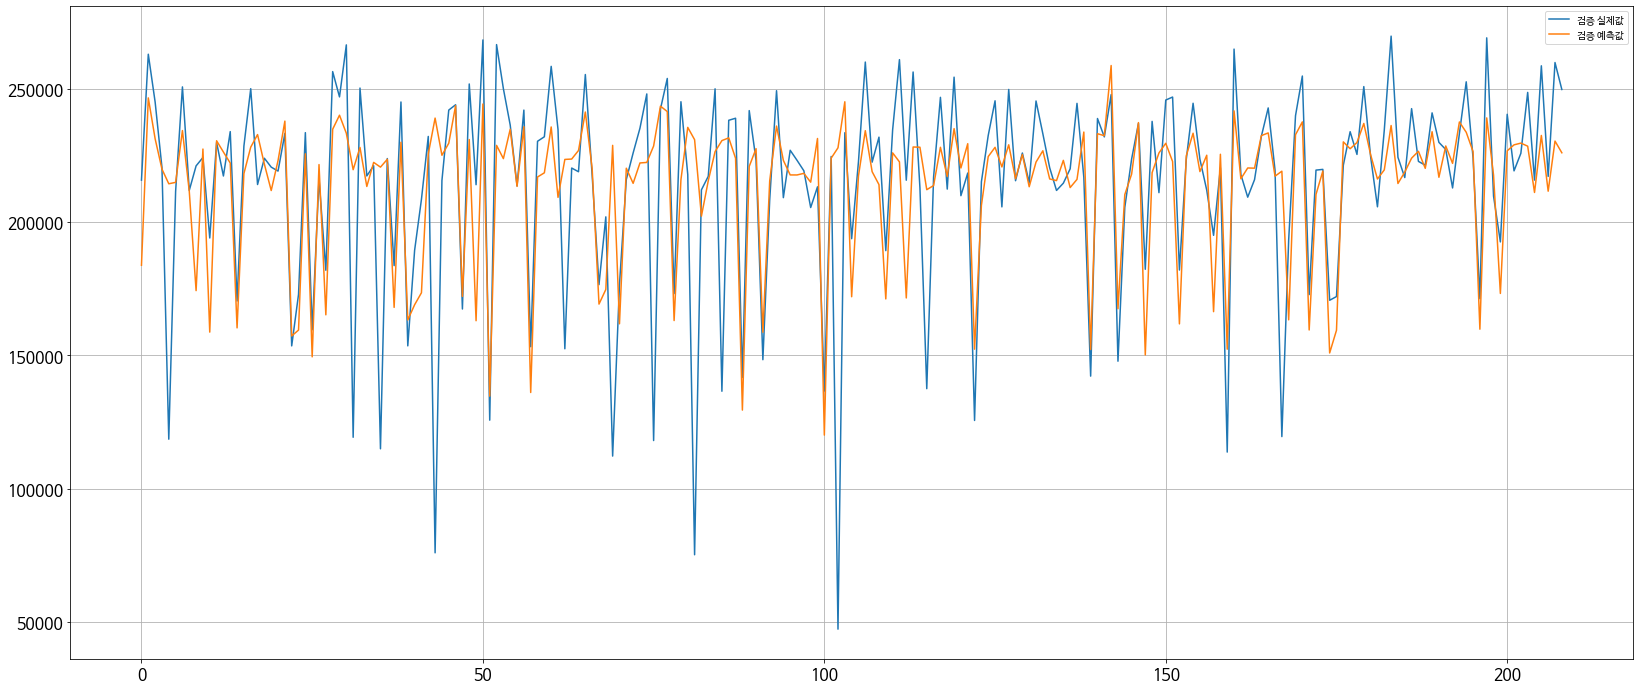

In [ ]:
best_model = clf.best_estimator_

y_pred = best_model.predict(X_gangnamweek_val)
mae = mean_absolute_error(y_gangnamweek_val, y_pred)
print(f'검증데이터 MAE: {mae:,.0f}')


df_visual = pd.DataFrame({'검증 실제값':y_gangnamweek_val,'검증 예측값':y_pred})
df_visual.reset_index(inplace=True)

df_visual[['검증 실제값','검증 예측값']].plot(figsize=(28,12),grid=True,fontsize=16)

# 3. 모델 해석

## 3-1. 특성들의 상관계수

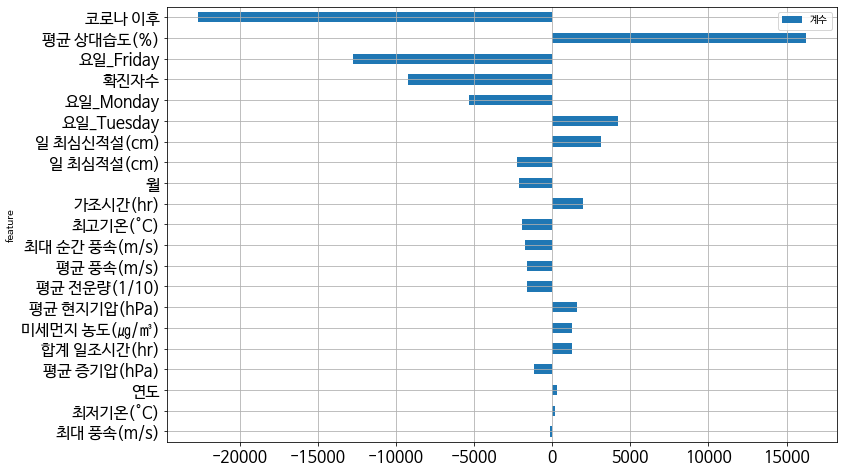

In [ ]:
# 회귀계수
coefficients = best_model['ridge'].coef_

# best_features = ['요일_Tuesday', '요일_Thursday', '요일_Monday', '요일_Friday', '최저기온(°C)',
#        '최고기온(°C)', '강수 계속시간(hr)', '최대 순간 풍속(m/s)', '최대 풍속(m/s)', '평균 풍속(m/s)',
#        '평균 상대습도(%)', '평균 증기압(hPa)', '평균 현지기압(hPa)', '가조시간(hr)', '합계 일조시간(hr)',
#        '일 최심신적설(cm)', '일 최심적설(cm)', '평균 전운량(1/10)', '확진자수', '연도', '월',
#        '코로나 이후', '미세먼지 농도(㎍/㎥)']  # 23

# best_features = ['요일_Tuesday', '요일_Monday', '요일_Friday', '최저기온(°C)', '최고기온(°C)',
#        '강수 계속시간(hr)', '최대 순간 풍속(m/s)', '최대 풍속(m/s)', '평균 풍속(m/s)',
#        '평균 상대습도(%)', '평균 증기압(hPa)', '평균 현지기압(hPa)', '가조시간(hr)', '합계 일조시간(hr)',
#        '일 최심신적설(cm)', '일 최심적설(cm)', '평균 전운량(1/10)', '확진자수', '연도', '월',
#        '코로나 이후', '미세먼지 농도(㎍/㎥)']  # 22

best_features = ['요일_Tuesday',
 '요일_Monday',
 '요일_Friday',
 '최저기온(°C)',
 '최고기온(°C)',
 '최대 순간 풍속(m/s)',
 '최대 풍속(m/s)',
 '평균 풍속(m/s)',
 '평균 상대습도(%)',
 '평균 증기압(hPa)',
 '평균 현지기압(hPa)',
 '가조시간(hr)',
 '합계 일조시간(hr)',
 '일 최심신적설(cm)',
 '일 최심적설(cm)',
 '평균 전운량(1/10)',
 '확진자수',
 '연도',
 '월',
 '코로나 이후',
 '미세먼지 농도(㎍/㎥)']

pd.Series(coefficients,best_features) 
df_best_features = pd.DataFrame({'feature':best_features,'계수':coefficients}) 
df_best_features['절대값']=abs(df_best_features['계수'])
df_best_features.sort_values(by='절대값',ascending=True,inplace=True)
df_best_features.plot.barh(x='feature',y='계수',figsize=(12,8),grid=True,fontsize=16)
# df.plot.bar(x='lab', y='val', rot=0)

모델이 어떻게 예측을 하는지 해석해보겠습니다. 해석을 하기위해 상관계수를 활용하였습니다. 
이미지는 최적파라미터에 사용된 특성의 상관계수를 그래프로 나타낸 것입니다. 오른쪽으로 뻗어있는 것은 승객수와 양의 상관관계를 이루고 왼쪽으로 뻗어있는 것은 음의 상관관계를 이루는 것입니다. 코로나 이후의 기간에 코로나 이후라는 특성을 적용하였는데 이 특성으로 승객수가 많이 감소하는 영향이 있는 것을 알 수 있습니다. 주요 특성 중 이해가 잘 되지 않는 특성들을 좀 더 살펴보았습니다.


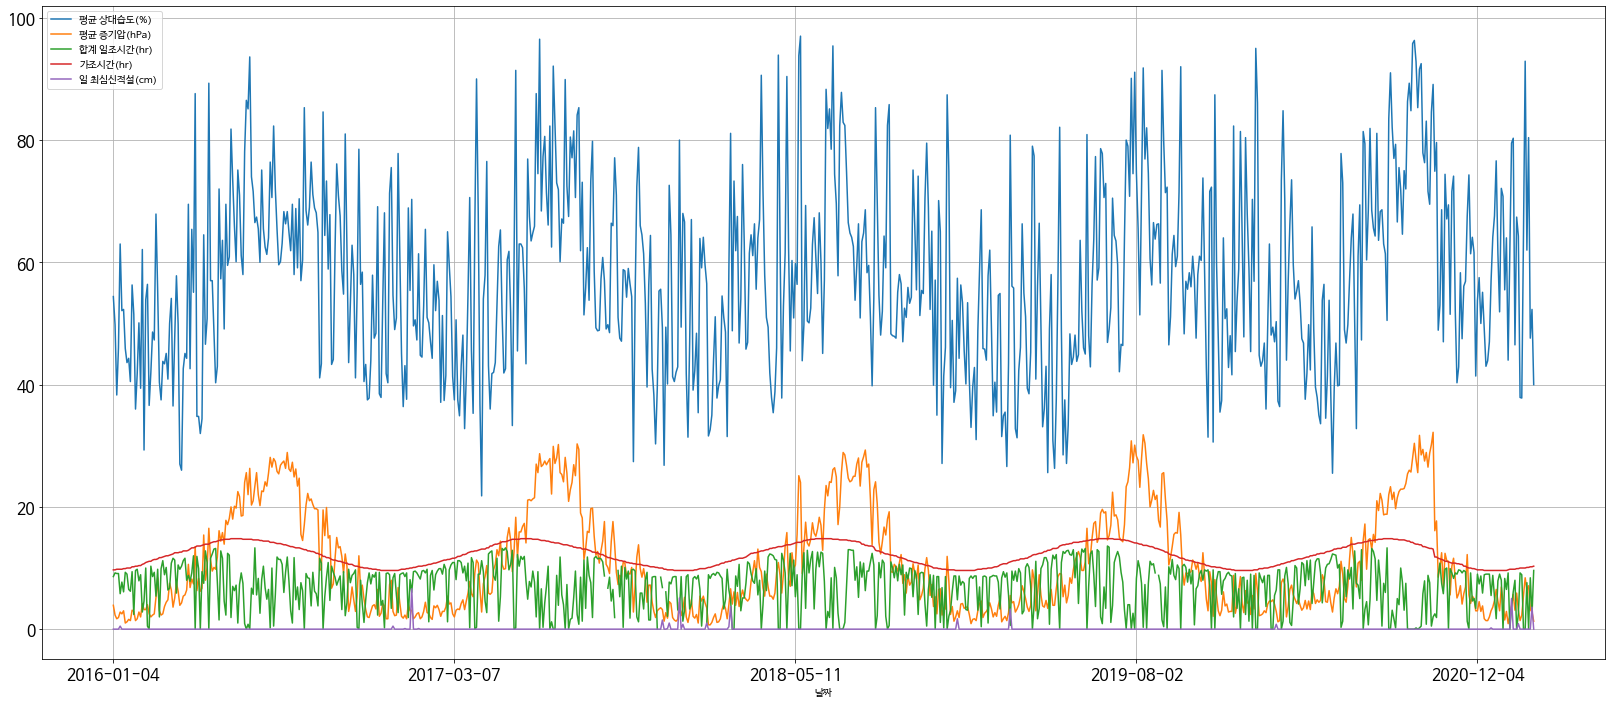

In [ ]:
df_hpahr = gangnamweek_train[['날짜','평균 상대습도(%)','평균 증기압(hPa)','합계 일조시간(hr)','가조시간(hr)','일 최심신적설(cm)']].sort_values(by ='날짜')
df_hpahr.set_index('날짜',inplace=True)
df_hpahr
df_hpahr[['평균 상대습도(%)','평균 증기압(hPa)','합계 일조시간(hr)','가조시간(hr)','일 최심신적설(cm)']].plot(figsize=(28,12),grid=True,fontsize=16)
# df_hpahr[['일 최심신적설(cm)']].plot(figsize=(28,12),grid=True,fontsize=16)

# plt.xticks(np.arange(0, 834,365))

주요 특성을 날짜별로 수치를 확인해보니 계절성을 나타내는 것을 알 수 있었습니다. 이것을 다시 특성에 대입해서 생각해보았습니다.

평균 상대습도는 여름에 높아지기 때문에 여름이 되면 대체로 승하차승객수가 증가하는 것으로 해석할 수 있습니다. 최고기온도 여름에 높아지는데 이것은 음수로 나타나고 있습니다. 이러한 것은 상관계수가 모든데이터의 평균치이고 21개 특성의 상관계수가 종합적으로 계산되어 예측하는 것이기에 상쇄하며 생각해보면 될 것 같습니다. 


In [ ]:
# test 실제값과 예측값 ,그래프 시각화 비교

y_pred = best_model.predict(X_gangnamweek_test)
mae = mean_absolute_error(y_gangnamweek_test, y_pred)
print(f'검증데이터 MAE: {mae:,.0f}')


검증데이터 MAE: 19,134


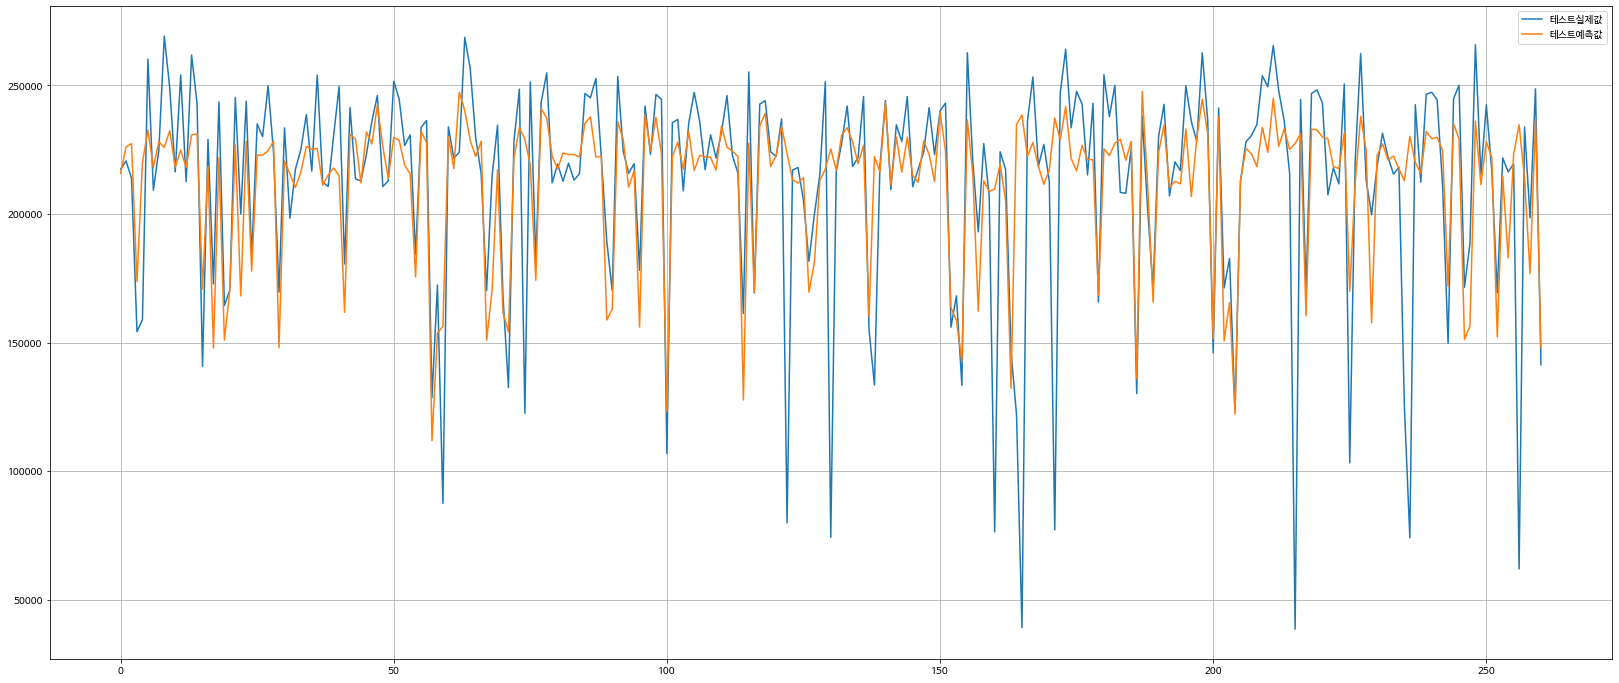

In [ ]:
df_visual = pd.DataFrame({'테스트실제값':y_gangnamweek_test,'테스트예측값':y_pred})
df_visual.reset_index(inplace=True)

df_visual[['테스트실제값','테스트예측값']].plot(figsize=(28,12),grid=True)


**한계점**


실제 미래를 예측하는데 적용시, 관측된 데이터가 없어서 예측된 값으로 예측을 해야합니다.
* 예측이 비교적 정확하고 쉬운 요소
      요일,기온,증기압,가조시간
* 불확실한 요소,코로나 확진자수
      미세먼지 농도,강수량 등


 이 과정에서 오차가 발생할 수 있습니다. 요일과 기온 등 비교적 정확하고 예측이 쉬운요소들도 있지만, 코로나 확진자수나 미세먼지 농도와 같이 불확실한 요소들도 있는데요, 몇가지 케이스로 나누어서 예측 시나리오를 그려보면 좋을 것 같습니다. 
